In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/CIRUGIA GENERAL.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=240.8, y1=127.3
Page 1, Q1, A: Yellow pixels: 1894
Page 1, Q1, A: Total non-white pixels: 2996
Page 1, Q1, A: Yellow percentage: 63.2%


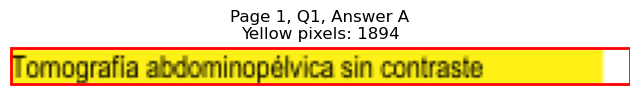

Page 1, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=243.8, y1=139.9
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 1089
Page 1, Q1, B: Yellow percentage: 0.0%


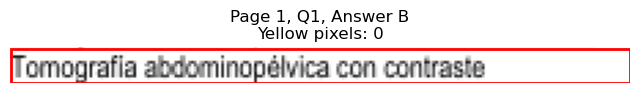

Page 1, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=479.6, y1=127.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 771
Page 1, Q1, C: Yellow percentage: 0.0%


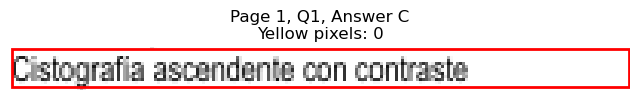

Page 1, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=432.4, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 552
Page 1, Q1, D: Yellow percentage: 0.0%


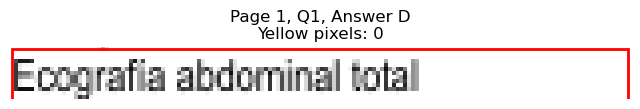


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=185.2, y1=203.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 569
Page 1, Q2, A: Yellow percentage: 0.0%


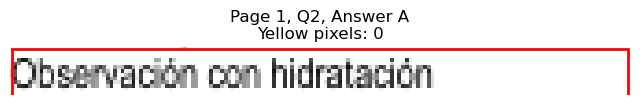

Page 1, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=151.1, y1=215.6
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 433
Page 1, Q2, B: Yellow percentage: 0.0%


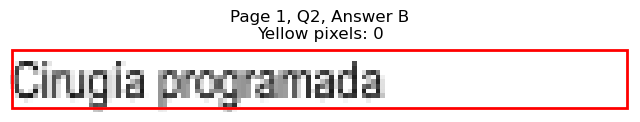

Page 1, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=430.4, y1=203.0
Page 1, Q2, C: Yellow pixels: 1595
Page 1, Q2, C: Total non-white pixels: 2002
Page 1, Q2, C: Yellow percentage: 79.7%


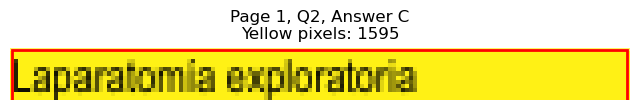

Page 1, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=448.9, y1=215.6
Page 1, Q2, D: Yellow pixels: 169
Page 1, Q2, D: Total non-white pixels: 776
Page 1, Q2, D: Yellow percentage: 21.8%


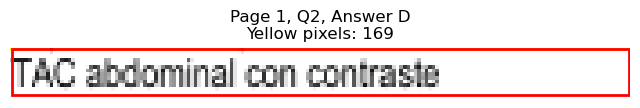


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=150.6, y1=266.1
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 450
Page 1, Q3, A: Yellow percentage: 0.0%


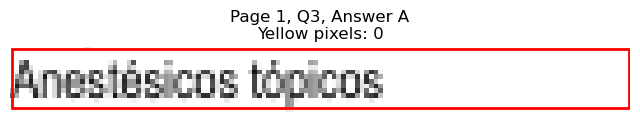

Page 1, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=137.1, y1=278.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 359
Page 1, Q3, B: Yellow percentage: 0.0%


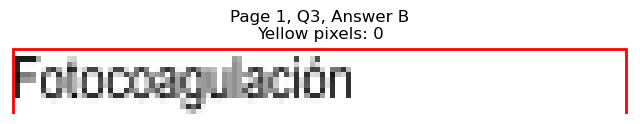

Page 1, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=374.2, y1=266.1
Page 1, Q3, C: Yellow pixels: 98
Page 1, Q3, C: Total non-white pixels: 350
Page 1, Q3, C: Yellow percentage: 28.0%


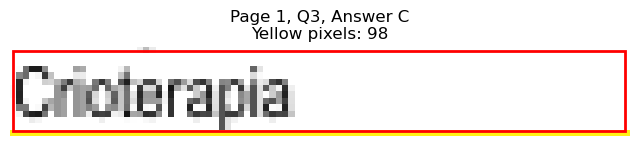

Page 1, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=363.7, y1=278.7
Page 1, Q3, D: Yellow pixels: 989
Page 1, Q3, D: Total non-white pixels: 1131
Page 1, Q3, D: Yellow percentage: 87.4%


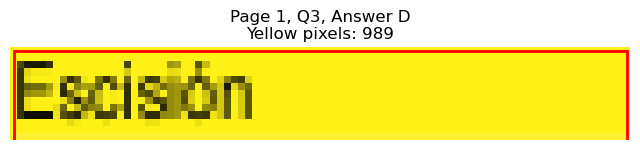


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=135.0, y1=329.3
Page 1, Q4, A: Yellow pixels: 118
Page 1, Q4, A: Total non-white pixels: 471
Page 1, Q4, A: Yellow percentage: 25.1%


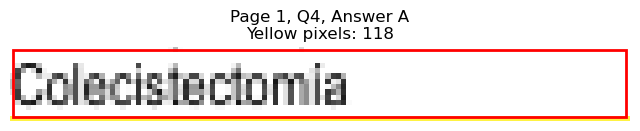

Page 1, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=95.9, y1=341.9
Page 1, Q4, B: Yellow pixels: 904
Page 1, Q4, B: Total non-white pixels: 1014
Page 1, Q4, B: Yellow percentage: 89.2%


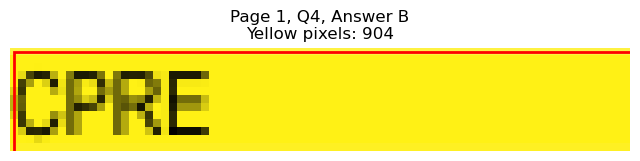

Page 1, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=394.3, y1=329.3
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 331
Page 1, Q4, C: Yellow percentage: 0.0%


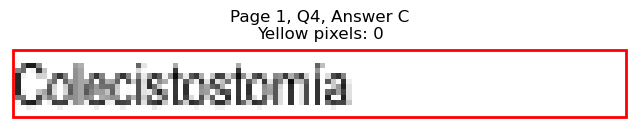

Page 1, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=390.8, y1=341.9
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 331
Page 1, Q4, D: Yellow percentage: 0.0%


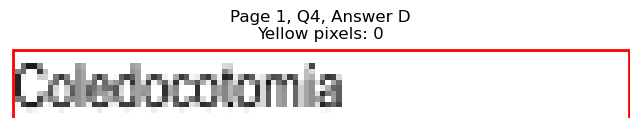


Page 1, Q4 - Selected Answer: B (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=161.1, y1=379.8
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 576
Page 1, Q5, A: Yellow percentage: 0.0%


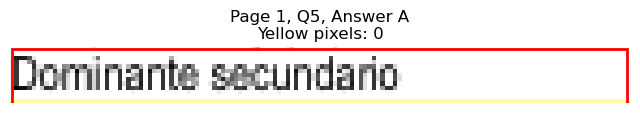

Page 1, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=93.9, y1=392.4
Page 1, Q5, B: Yellow pixels: 835
Page 1, Q5, B: Total non-white pixels: 1064
Page 1, Q5, B: Yellow percentage: 78.5%


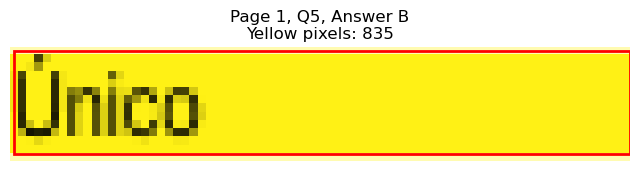

Page 1, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=398.2, y1=379.8
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 360
Page 1, Q5, C: Yellow percentage: 0.0%


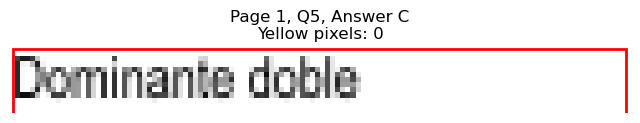

Page 1, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=381.2, y1=392.4
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 278
Page 1, Q5, D: Yellow percentage: 0.0%


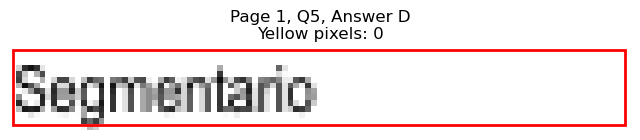


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=144.5, y1=442.9
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 405
Page 1, Q6, A: Yellow percentage: 0.0%


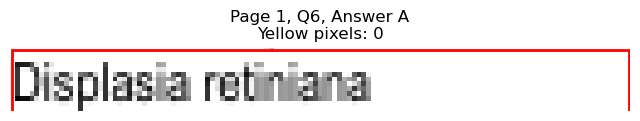

Page 1, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=175.1, y1=455.5
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 529
Page 1, Q6, B: Yellow percentage: 0.0%


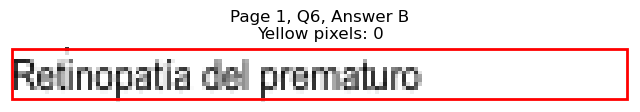

Page 1, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=385.3, y1=442.9
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 409
Page 1, Q6, C: Yellow percentage: 0.0%


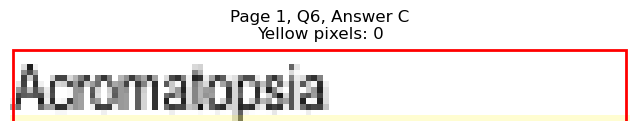

Page 1, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=390.2, y1=455.5
Page 1, Q6, D: Yellow pixels: 1249
Page 1, Q6, D: Total non-white pixels: 1596
Page 1, Q6, D: Yellow percentage: 78.3%


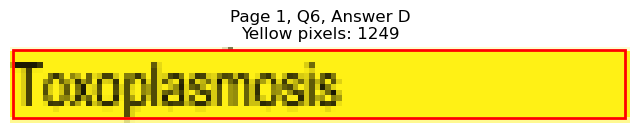


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=147.0, y1=506.0
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 375
Page 1, Q7, A: Yellow percentage: 0.0%


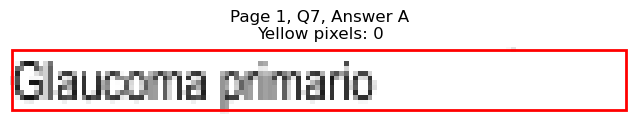

Page 1, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=163.1, y1=518.6
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 448
Page 1, Q7, B: Yellow percentage: 0.0%


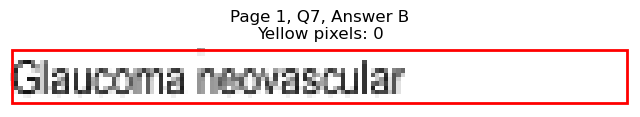

Page 1, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=417.8, y1=506.0
Page 1, Q7, C: Yellow pixels: 141
Page 1, Q7, C: Total non-white pixels: 742
Page 1, Q7, C: Yellow percentage: 19.0%


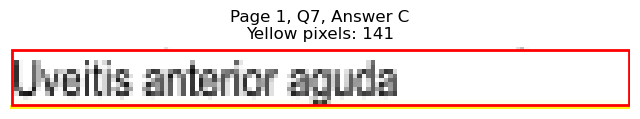

Page 1, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=451.4, y1=518.6
Page 1, Q7, D: Yellow pixels: 1750
Page 1, Q7, D: Total non-white pixels: 2450
Page 1, Q7, D: Yellow percentage: 71.4%


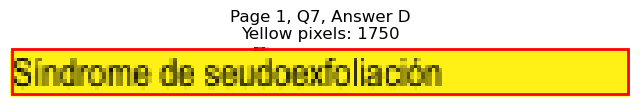


Page 1, Q7 - Selected Answer: D (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=159.6, y1=581.8
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 485
Page 1, Q8, A: Yellow percentage: 0.0%


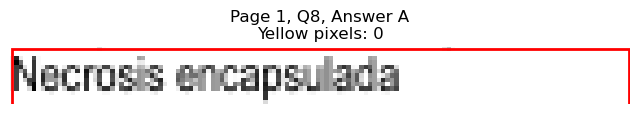

Page 1, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=186.6, y1=594.4
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 575
Page 1, Q8, B: Yellow percentage: 0.0%


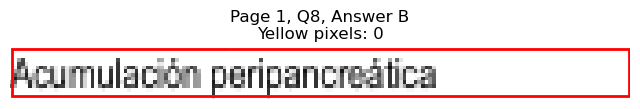

Page 1, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=420.8, y1=581.8
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 605
Page 1, Q8, C: Yellow percentage: 0.0%


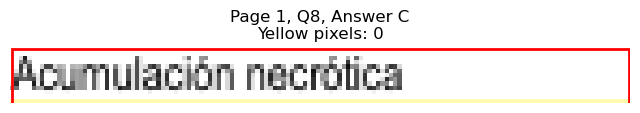

Page 1, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=380.2, y1=594.4
Page 1, Q8, D: Yellow pixels: 1058
Page 1, Q8, D: Total non-white pixels: 1456
Page 1, Q8, D: Yellow percentage: 72.7%


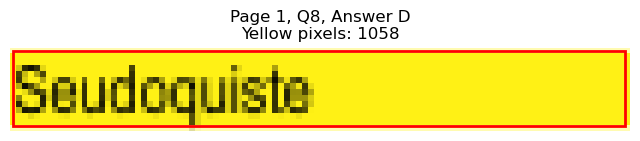


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=174.1, y1=632.3
Page 1, Q9, A: Yellow pixels: 157
Page 1, Q9, A: Total non-white pixels: 666
Page 1, Q9, A: Yellow percentage: 23.6%


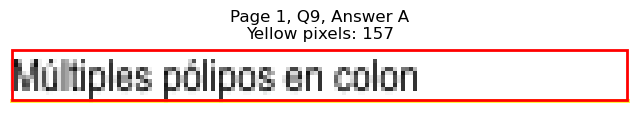

Page 1, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=173.1, y1=644.9
Page 1, Q9, B: Yellow pixels: 1647
Page 1, Q9, B: Total non-white pixels: 2028
Page 1, Q9, B: Yellow percentage: 81.2%


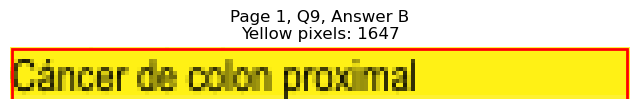

Page 1, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=439.9, y1=632.3
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 539
Page 1, Q9, C: Yellow percentage: 0.0%


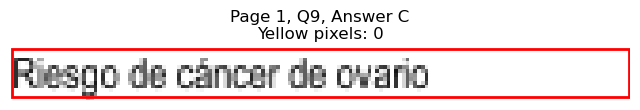

Page 1, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=411.8, y1=644.9
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 413
Page 1, Q9, D: Yellow percentage: 0.0%


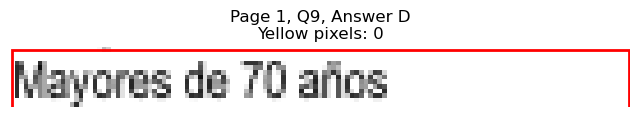


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=708.0, x1=167.1, y1=720.6
Page 1, Q10, A: Yellow pixels: 1565
Page 1, Q10, A: Total non-white pixels: 2100
Page 1, Q10, A: Yellow percentage: 74.5%


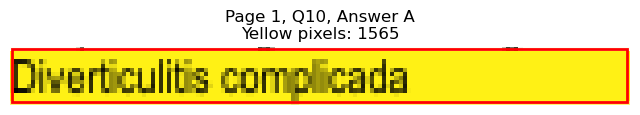

Page 1, Q10 - B: Detected box: x0=68.3, y0=720.6, x1=179.7, y1=733.2
Page 1, Q10, B: Yellow pixels: 162
Page 1, Q10, B: Total non-white pixels: 712
Page 1, Q10, B: Yellow percentage: 22.8%


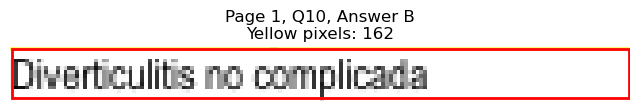

Page 1, Q10 - C: Detected box: x0=327.5, y0=708.0, x1=403.7, y1=720.6
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 389
Page 1, Q10, C: Yellow percentage: 0.0%


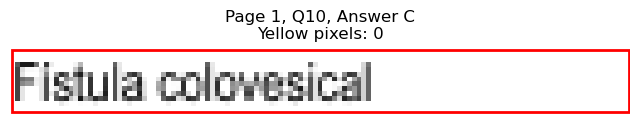

Page 1, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=404.8, y1=733.2
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 405
Page 1, Q10, D: Yellow percentage: 0.0%


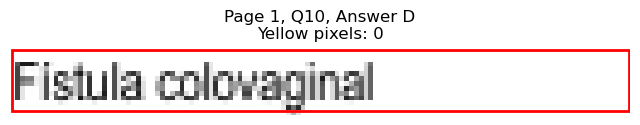


Page 1, Q10 - Selected Answer: A (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=65.2, y1=102.1
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 65
Page 2, Q1, A: Yellow percentage: 0.0%


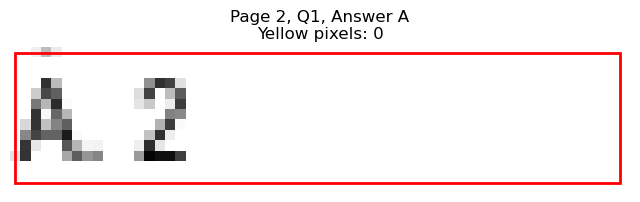

Page 2, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=65.2, y1=114.7
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 73
Page 2, Q1, B: Yellow percentage: 0.0%


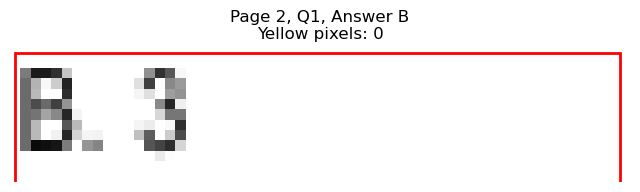

Page 2, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=340.1, y1=102.1
Page 2, Q1, C: Yellow pixels: 64
Page 2, Q1, C: Total non-white pixels: 108
Page 2, Q1, C: Yellow percentage: 59.3%


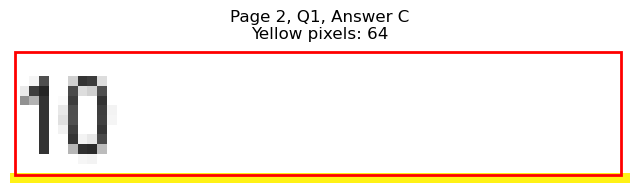

Page 2, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=324.4, y1=114.7
Page 2, Q1, D: Yellow pixels: 730
Page 2, Q1, D: Total non-white pixels: 780
Page 2, Q1, D: Yellow percentage: 93.6%


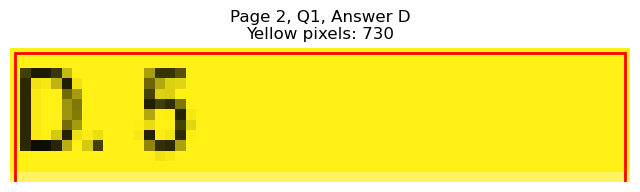


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=173.7, y1=177.8
Page 2, Q2, A: Yellow pixels: 1
Page 2, Q2, A: Total non-white pixels: 667
Page 2, Q2, A: Yellow percentage: 0.1%


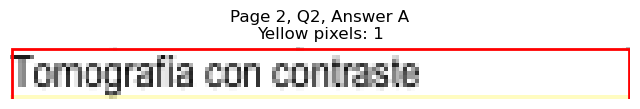

Page 2, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=170.7, y1=190.4
Page 2, Q2, B: Yellow pixels: 1464
Page 2, Q2, B: Total non-white pixels: 2142
Page 2, Q2, B: Yellow percentage: 68.3%


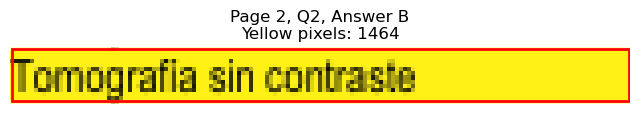

Page 2, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=412.9, y1=177.8
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 452
Page 2, Q2, C: Yellow percentage: 0.0%


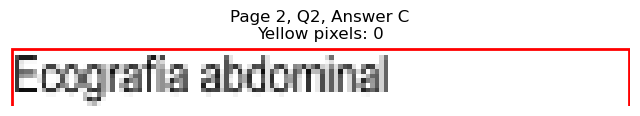

Page 2, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=458.0, y1=190.4
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 685
Page 2, Q2, D: Yellow percentage: 0.0%


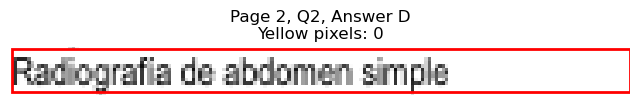


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=160.1, y1=240.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 459
Page 2, Q3, A: Yellow percentage: 0.0%


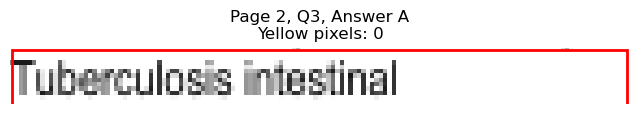

Page 2, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=141.0, y1=253.5
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 356
Page 2, Q3, B: Yellow percentage: 0.0%


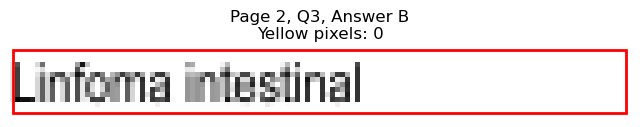

Page 2, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=395.7, y1=240.9
Page 2, Q3, C: Yellow pixels: 1282
Page 2, Q3, C: Total non-white pixels: 1547
Page 2, Q3, C: Yellow percentage: 82.9%


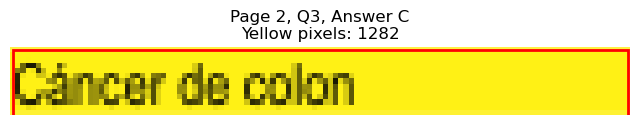

Page 2, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=410.8, y1=253.5
Page 2, Q3, D: Yellow pixels: 134
Page 2, Q3, D: Total non-white pixels: 557
Page 2, Q3, D: Yellow percentage: 24.1%


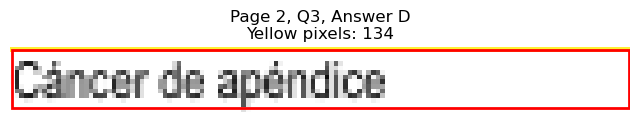


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=121.5, y1=341.9
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 263
Page 2, Q4, A: Yellow percentage: 0.0%


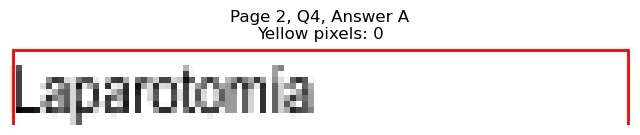

Page 2, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=121.5, y1=354.6
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 272
Page 2, Q4, B: Yellow percentage: 0.0%


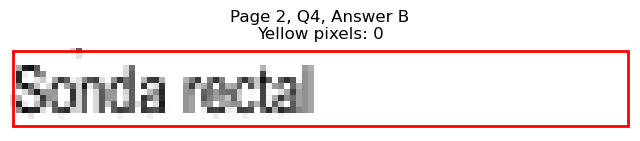

Page 2, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=366.7, y1=341.9
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 177
Page 2, Q4, C: Yellow percentage: 0.0%


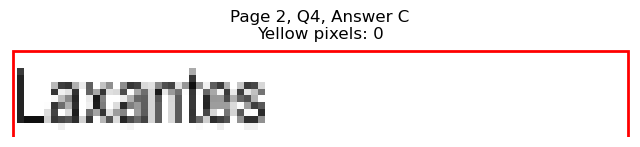

Page 2, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=450.9, y1=354.6
Page 2, Q4, D: Yellow pixels: 1775
Page 2, Q4, D: Total non-white pixels: 2436
Page 2, Q4, D: Yellow percentage: 72.9%


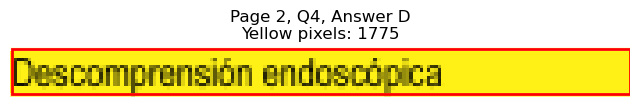


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=161.5, y1=417.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 488
Page 2, Q5, A: Yellow percentage: 0.0%


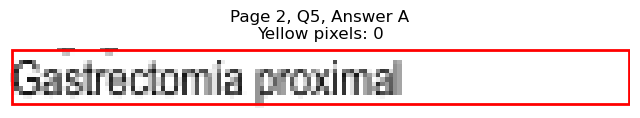

Page 2, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=262.6, y1=430.3
Page 2, Q5, B: Yellow pixels: 1870
Page 2, Q5, B: Total non-white pixels: 2996
Page 2, Q5, B: Yellow percentage: 62.4%


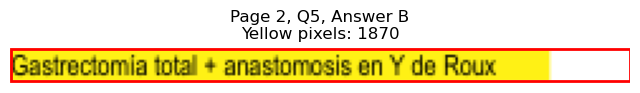

Page 2, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=455.0, y1=417.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 649
Page 2, Q5, C: Yellow percentage: 0.0%


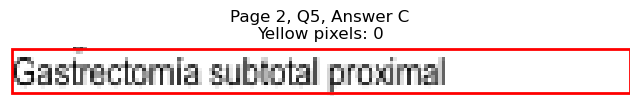

Page 2, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=436.4, y1=430.3
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 552
Page 2, Q5, D: Yellow percentage: 0.0%


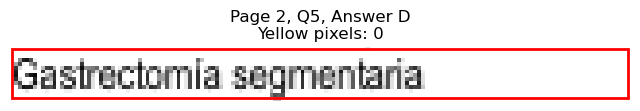


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=137.1, y1=493.4
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 361
Page 2, Q6, A: Yellow percentage: 0.0%


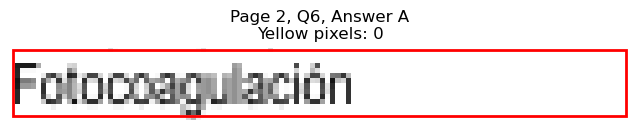

Page 2, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=128.5, y1=506.0
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 324
Page 2, Q6, B: Yellow percentage: 0.0%


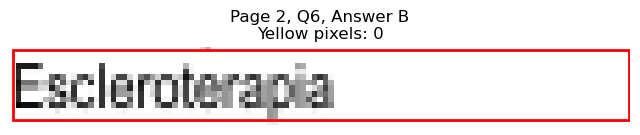

Page 2, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=404.2, y1=493.4
Page 2, Q6, C: Yellow pixels: 1246
Page 2, Q6, C: Total non-white pixels: 1792
Page 2, Q6, C: Yellow percentage: 69.5%


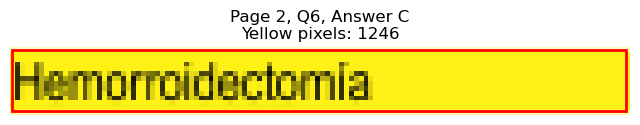

Page 2, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=424.9, y1=506.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 623
Page 2, Q6, D: Yellow percentage: 0.0%


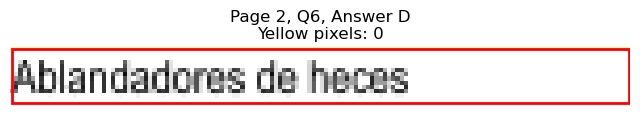


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=556.5, x1=148.1, y1=569.2
Page 2, Q7, A: Yellow pixels: 131
Page 2, Q7, A: Total non-white pixels: 546
Page 2, Q7, A: Yellow percentage: 24.0%


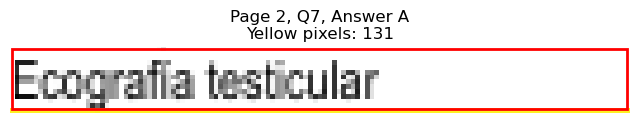

Page 2, Q7 - B: Detected box: x0=68.3, y0=569.1, x1=160.1, y1=581.8
Page 2, Q7, B: Yellow pixels: 1461
Page 2, Q7, B: Total non-white pixels: 1859
Page 2, Q7, B: Yellow percentage: 78.6%


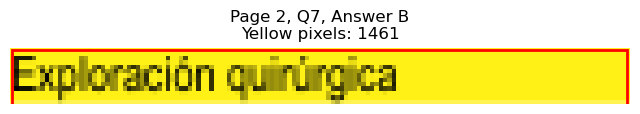

Page 2, Q7 - C: Detected box: x0=327.5, y0=556.5, x1=438.9, y1=569.2
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 532
Page 2, Q7, C: Yellow percentage: 0.0%


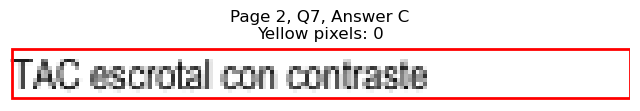

Page 2, Q7 - D: Detected box: x0=327.5, y0=569.1, x1=434.9, y1=581.8
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 542
Page 2, Q7, D: Yellow percentage: 0.0%


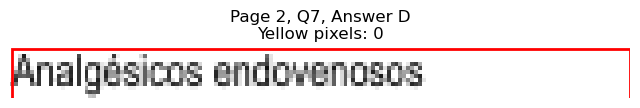


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=644.9, x1=135.0, y1=657.5
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 361
Page 2, Q8, A: Yellow percentage: 0.0%


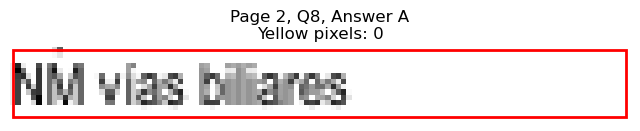

Page 2, Q8 - B: Detected box: x0=68.3, y0=657.5, x1=136.5, y1=670.1
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 351
Page 2, Q8, B: Yellow percentage: 0.0%


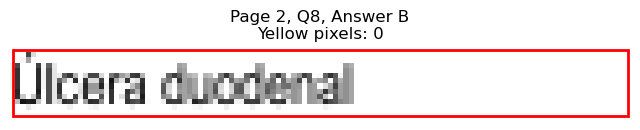

Page 2, Q8 - C: Detected box: x0=327.5, y0=644.9, x1=422.3, y1=657.5
Page 2, Q8, C: Yellow pixels: 146
Page 2, Q8, C: Total non-white pixels: 638
Page 2, Q8, C: Yellow percentage: 22.9%


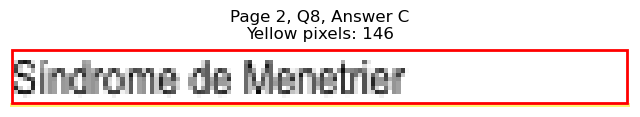

Page 2, Q8 - D: Detected box: x0=327.5, y0=657.5, x1=386.2, y1=670.1
Page 2, Q8, D: Yellow pixels: 1183
Page 2, Q8, D: Total non-white pixels: 1540
Page 2, Q8, D: Yellow percentage: 76.8%


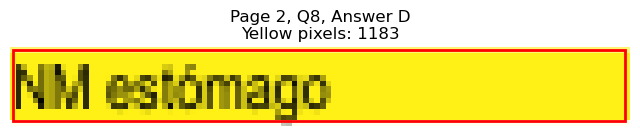


Page 2, Q8 - Selected Answer: D (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=733.2, x1=194.7, y1=745.8
Page 2, Q9, A: Yellow pixels: 1793
Page 2, Q9, A: Total non-white pixels: 2301
Page 2, Q9, A: Yellow percentage: 77.9%


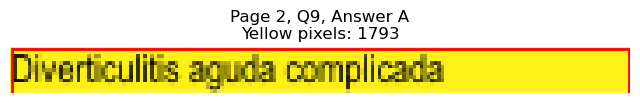

Page 2, Q9 - B: Detected box: x0=68.3, y0=745.8, x1=190.2, y1=758.4
Page 2, Q9, B: Yellow pixels: 172
Page 2, Q9, B: Total non-white pixels: 798
Page 2, Q9, B: Yellow percentage: 21.6%


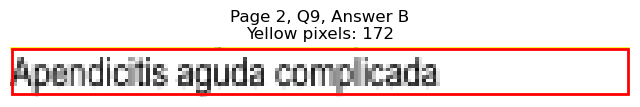

Page 2, Q9 - C: Detected box: x0=327.5, y0=733.2, x1=421.9, y1=745.8
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 467
Page 2, Q9, C: Yellow percentage: 0.0%


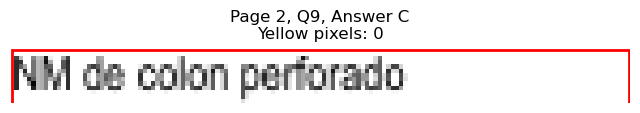

Page 2, Q9 - D: Detected box: x0=327.5, y0=745.8, x1=423.3, y1=758.4
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 487
Page 2, Q9, D: Yellow percentage: 0.0%


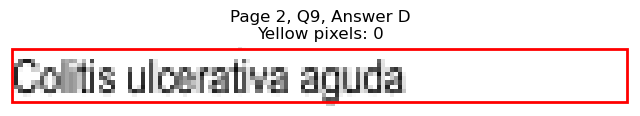


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=209.8, y1=127.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 701
Page 3, Q1, A: Yellow percentage: 0.0%


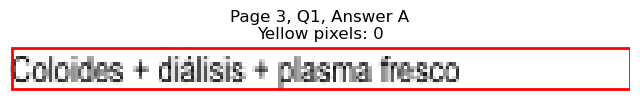

Page 3, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=245.8, y1=139.9
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 859
Page 3, Q1, B: Yellow percentage: 0.0%


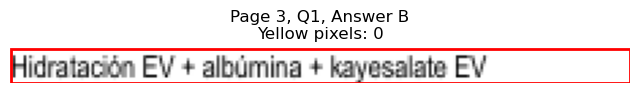

Page 3, Q1 - C: Detected box: x0=68.8, y0=139.9, x1=300.0, y1=152.6
Page 3, Q1, C: Yellow pixels: 283
Page 3, Q1, C: Total non-white pixels: 1357
Page 3, Q1, C: Yellow percentage: 20.9%


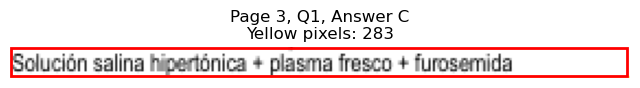

Page 3, Q1 - D: Detected box: x0=68.8, y0=152.5, x1=254.4, y1=165.2
Page 3, Q1, D: Yellow pixels: 2366
Page 3, Q1, D: Total non-white pixels: 3318
Page 3, Q1, D: Yellow percentage: 71.3%


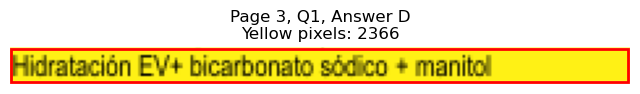


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=121.0, y1=203.0
Page 3, Q2, A: Yellow pixels: 1147
Page 3, Q2, A: Total non-white pixels: 1339
Page 3, Q2, A: Yellow percentage: 85.7%


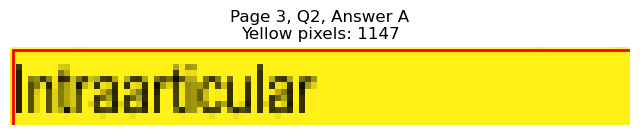

Page 3, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=107.4, y1=215.6
Page 3, Q2, B: Yellow pixels: 90
Page 3, Q2, B: Total non-white pixels: 305
Page 3, Q2, B: Yellow percentage: 29.5%


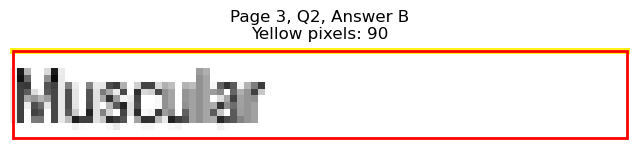

Page 3, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=354.7, y1=203.0
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 123
Page 3, Q2, C: Yellow percentage: 0.0%


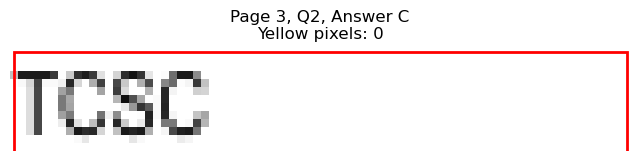

Page 3, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=351.7, y1=215.6
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 120
Page 3, Q2, D: Yellow percentage: 0.0%


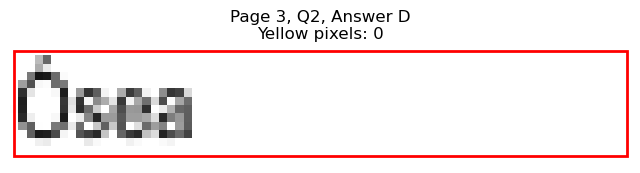


Page 3, Q2 - Selected Answer: A (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=116.4, y1=253.5
Page 3, Q3, A: Yellow pixels: 99
Page 3, Q3, A: Total non-white pixels: 370
Page 3, Q3, A: Yellow percentage: 26.8%


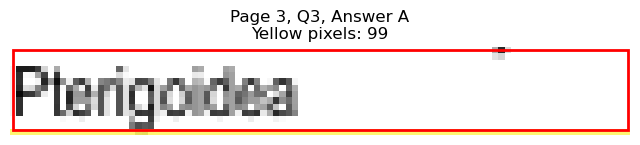

Page 3, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=118.5, y1=266.1
Page 3, Q3, B: Yellow pixels: 1118
Page 3, Q3, B: Total non-white pixels: 1414
Page 3, Q3, B: Yellow percentage: 79.1%


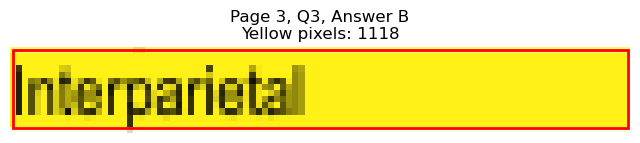

Page 3, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=362.7, y1=253.5
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 182
Page 3, Q3, C: Yellow percentage: 0.0%


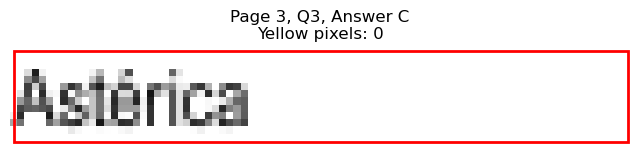

Page 3, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=361.6, y1=266.1
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 169
Page 3, Q3, D: Yellow percentage: 0.0%


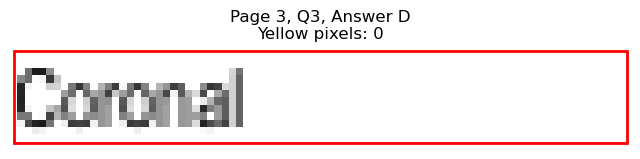


Page 3, Q3 - Selected Answer: B (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=148.6, y1=329.3
Page 3, Q4, A: Yellow pixels: 131
Page 3, Q4, A: Total non-white pixels: 547
Page 3, Q4, A: Yellow percentage: 23.9%


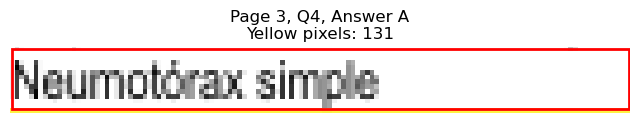

Page 3, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=159.0, y1=341.9
Page 3, Q4, B: Yellow pixels: 1506
Page 3, Q4, B: Total non-white pixels: 1846
Page 3, Q4, B: Yellow percentage: 81.6%


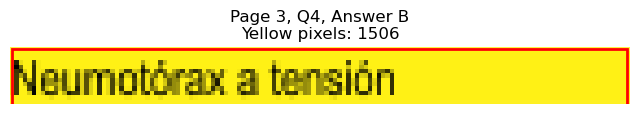

Page 3, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=374.2, y1=329.3
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 233
Page 3, Q4, C: Yellow percentage: 0.0%


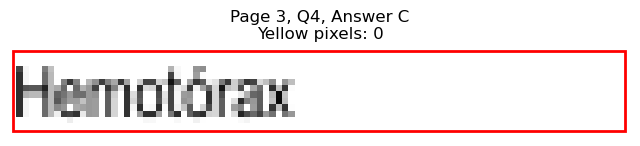

Page 3, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=410.8, y1=341.9
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 406
Page 3, Q4, D: Yellow percentage: 0.0%


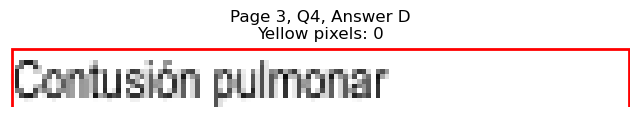


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=135.0, y1=405.0
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 339
Page 3, Q5, A: Yellow percentage: 0.0%


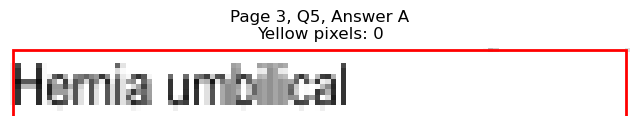

Page 3, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=147.0, y1=417.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 401
Page 3, Q5, B: Yellow percentage: 0.0%


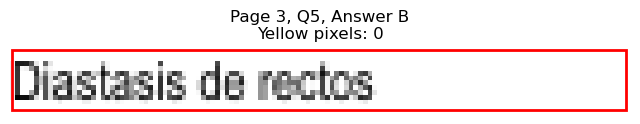

Page 3, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=402.3, y1=405.0
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 506
Page 3, Q5, C: Yellow percentage: 0.0%


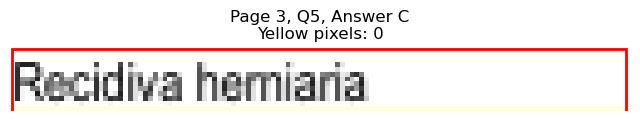

Page 3, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=402.8, y1=417.6
Page 3, Q5, D: Yellow pixels: 1325
Page 3, Q5, D: Total non-white pixels: 1764
Page 3, Q5, D: Yellow percentage: 75.1%


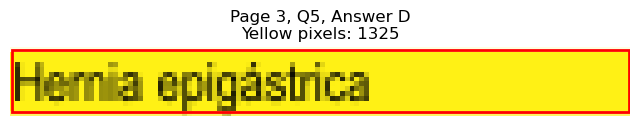


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=165.6, y1=468.1
Page 3, Q6, A: Yellow pixels: 148
Page 3, Q6, A: Total non-white pixels: 601
Page 3, Q6, A: Yellow percentage: 24.6%


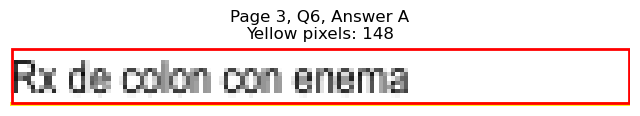

Page 3, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=173.7, y1=480.7
Page 3, Q6, B: Yellow pixels: 1639
Page 3, Q6, B: Total non-white pixels: 2028
Page 3, Q6, B: Yellow percentage: 80.8%


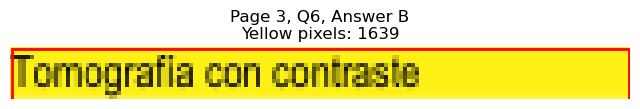

Page 3, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=399.3, y1=468.1
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 384
Page 3, Q6, C: Yellow percentage: 0.0%


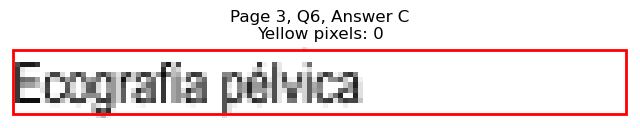

Page 3, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=407.8, y1=480.7
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 419
Page 3, Q6, D: Yellow percentage: 0.0%


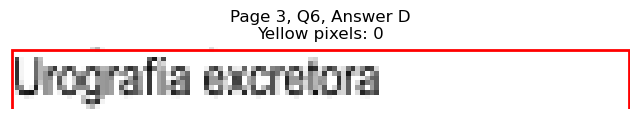


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=134.1, y1=518.6
Page 3, Q7, A: Yellow pixels: 117
Page 3, Q7, A: Total non-white pixels: 453
Page 3, Q7, A: Yellow percentage: 25.8%


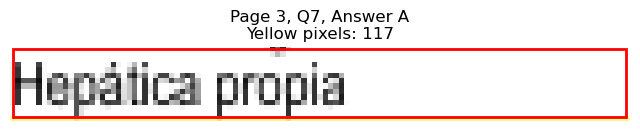

Page 3, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=109.9, y1=531.2
Page 3, Q7, B: Yellow pixels: 1013
Page 3, Q7, B: Total non-white pixels: 1288
Page 3, Q7, B: Yellow percentage: 78.6%


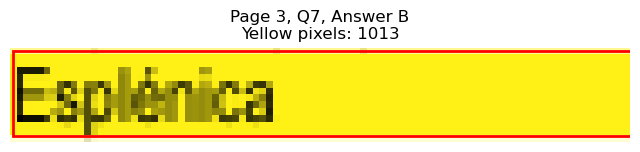

Page 3, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=409.3, y1=518.6
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 445
Page 3, Q7, C: Yellow percentage: 0.0%


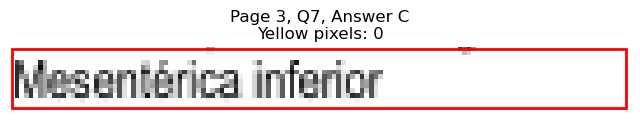

Page 3, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=394.4, y1=531.2
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 342
Page 3, Q7, D: Yellow percentage: 0.0%


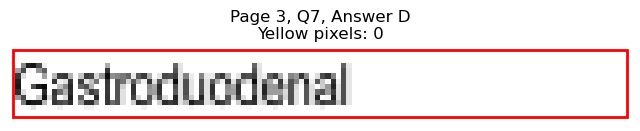


Page 3, Q7 - Selected Answer: B (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=193.7, y1=594.4
Page 3, Q8, A: Yellow pixels: 176
Page 3, Q8, A: Total non-white pixels: 777
Page 3, Q8, A: Yellow percentage: 22.7%


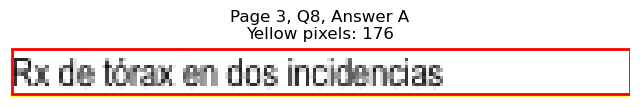

Page 3, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=126.0, y1=607.0
Page 3, Q8, B: Yellow pixels: 1195
Page 3, Q8, B: Total non-white pixels: 1417
Page 3, Q8, B: Yellow percentage: 84.3%


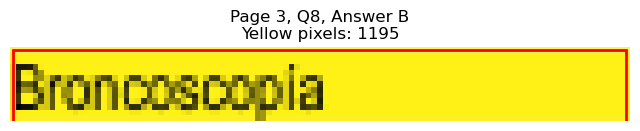

Page 3, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=453.9, y1=594.4
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 660
Page 3, Q8, C: Yellow percentage: 0.0%


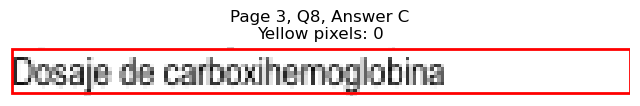

Page 3, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=436.9, y1=607.0
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 580
Page 3, Q8, D: Yellow percentage: 0.0%


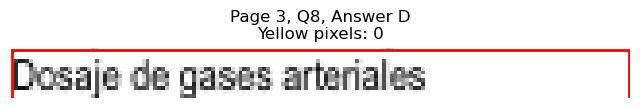


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=174.6, y1=670.1
Page 3, Q9, A: Yellow pixels: 1637
Page 3, Q9, A: Total non-white pixels: 2198
Page 3, Q9, A: Yellow percentage: 74.5%


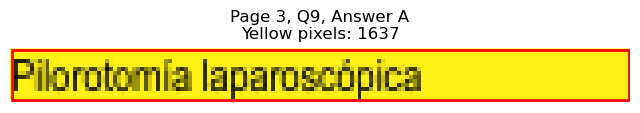

Page 3, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=172.1, y1=682.7
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 694
Page 3, Q9, B: Yellow percentage: 0.0%


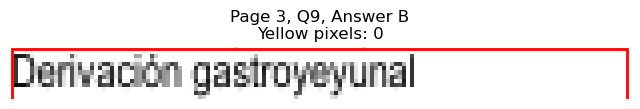

Page 3, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=446.0, y1=670.1
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 616
Page 3, Q9, C: Yellow percentage: 0.0%


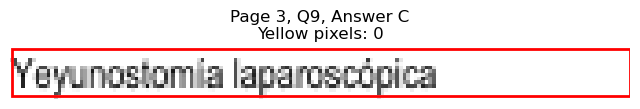

Page 3, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=421.4, y1=682.7
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 433
Page 3, Q9, D: Yellow percentage: 0.0%


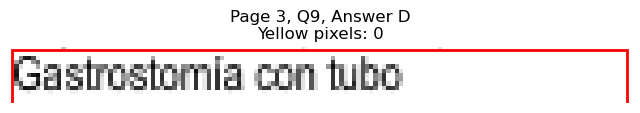


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=146.1, y1=745.8
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 384
Page 3, Q10, A: Yellow percentage: 0.0%


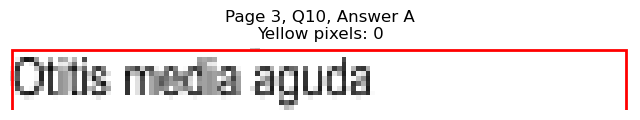

Page 3, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=150.0, y1=758.4
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 415
Page 3, Q10, B: Yellow percentage: 0.0%


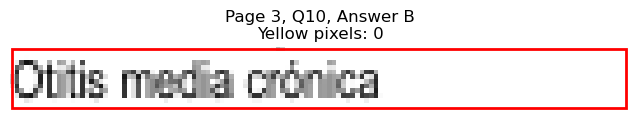

Page 3, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=417.3, y1=745.8
Page 3, Q10, C: Yellow pixels: 1503
Page 3, Q10, C: Total non-white pixels: 1833
Page 3, Q10, C: Yellow percentage: 82.0%


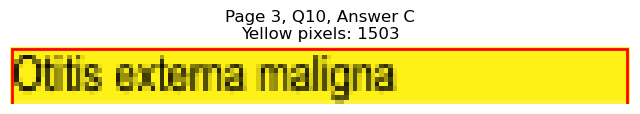

Page 3, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=397.8, y1=758.4
Page 3, Q10, D: Yellow pixels: 119
Page 3, Q10, D: Total non-white pixels: 525
Page 3, Q10, D: Yellow percentage: 22.7%


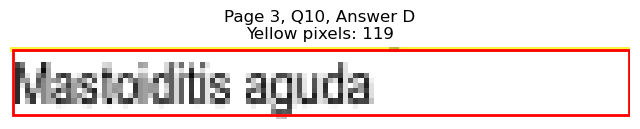


Page 3, Q10 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=186.1, y1=127.3
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 585
Page 4, Q1, A: Yellow percentage: 0.0%


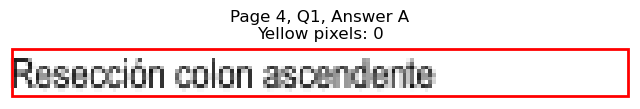

Page 4, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=135.5, y1=139.9
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 344
Page 4, Q1, B: Yellow percentage: 0.0%


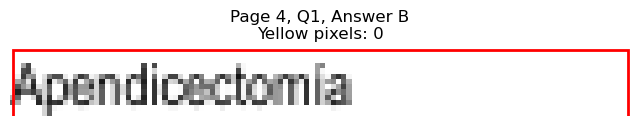

Page 4, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=429.9, y1=127.3
Page 4, Q1, C: Yellow pixels: 1417
Page 4, Q1, C: Total non-white pixels: 2142
Page 4, Q1, C: Yellow percentage: 66.2%


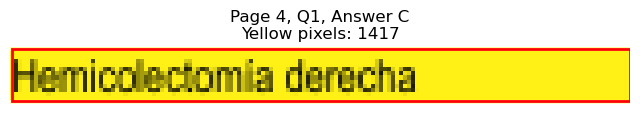

Page 4, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=371.7, y1=139.9
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 333
Page 4, Q1, D: Yellow percentage: 0.0%


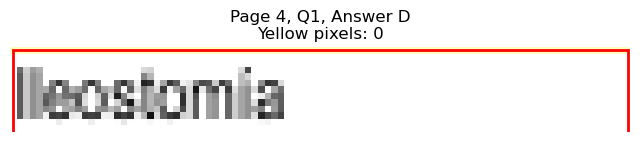


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=173.7, y1=203.0
Page 4, Q2, A: Yellow pixels: 1629
Page 4, Q2, A: Total non-white pixels: 2028
Page 4, Q2, A: Yellow percentage: 80.3%


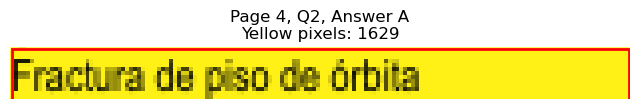

Page 4, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=179.2, y1=215.6
Page 4, Q2, B: Yellow pixels: 160
Page 4, Q2, B: Total non-white pixels: 699
Page 4, Q2, B: Yellow percentage: 22.9%


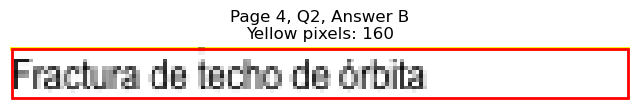

Page 4, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=411.8, y1=203.0
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 426
Page 4, Q2, C: Yellow percentage: 0.0%


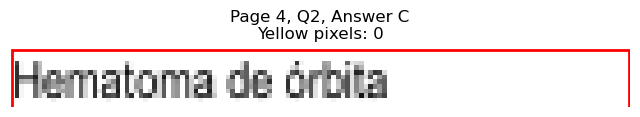

Page 4, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=411.8, y1=215.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 397
Page 4, Q2, D: Yellow percentage: 0.0%


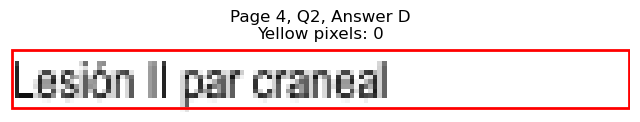


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=159.1, y1=253.5
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 455
Page 4, Q3, A: Yellow percentage: 0.0%


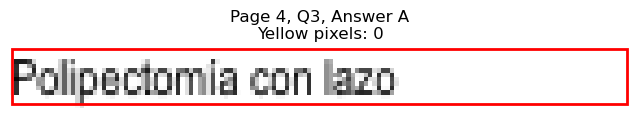

Page 4, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=206.2, y1=266.1
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 672
Page 4, Q3, B: Yellow percentage: 0.0%


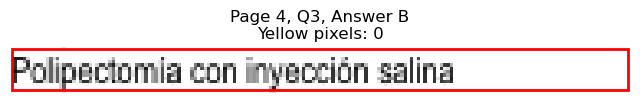

Page 4, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=427.9, y1=253.5
Page 4, Q3, C: Yellow pixels: 1542
Page 4, Q3, C: Total non-white pixels: 2114
Page 4, Q3, C: Yellow percentage: 72.9%


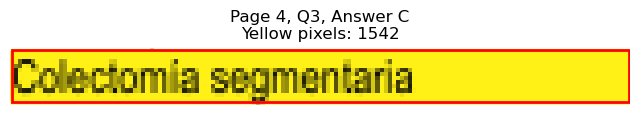

Page 4, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=433.9, y1=266.1
Page 4, Q3, D: Yellow pixels: 156
Page 4, Q3, D: Total non-white pixels: 707
Page 4, Q3, D: Yellow percentage: 22.1%


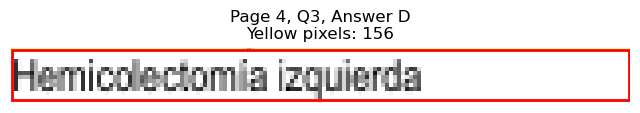


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=119.4, y1=329.3
Page 4, Q4, A: Yellow pixels: 102
Page 4, Q4, A: Total non-white pixels: 357
Page 4, Q4, A: Yellow percentage: 28.6%


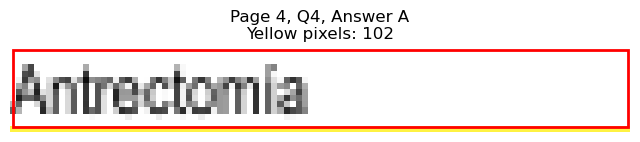

Page 4, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=162.6, y1=341.9
Page 4, Q4, B: Yellow pixels: 1501
Page 4, Q4, B: Total non-white pixels: 1885
Page 4, Q4, B: Yellow percentage: 79.6%


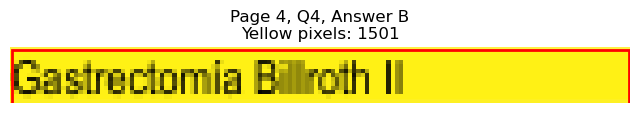

Page 4, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=419.3, y1=329.3
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 453
Page 4, Q4, C: Yellow percentage: 0.0%


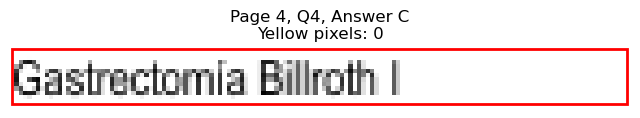

Page 4, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=403.7, y1=341.9
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 367
Page 4, Q4, D: Yellow percentage: 0.0%


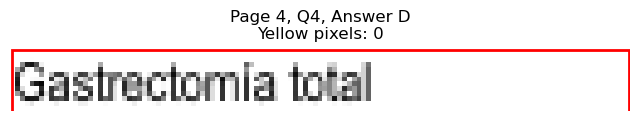


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=124.0, y1=392.4
Page 4, Q5, A: Yellow pixels: 1062
Page 4, Q5, A: Total non-white pixels: 1484
Page 4, Q5, A: Yellow percentage: 71.6%


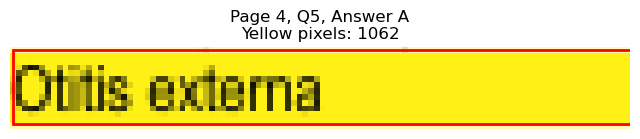

Page 4, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=146.1, y1=405.0
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 508
Page 4, Q5, B: Yellow percentage: 0.0%


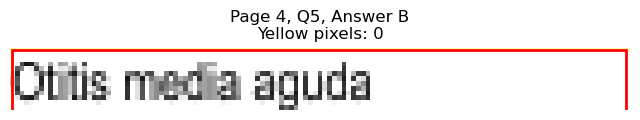

Page 4, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=409.3, y1=392.4
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 411
Page 4, Q5, C: Yellow percentage: 0.0%


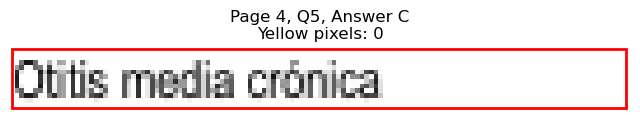

Page 4, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=411.3, y1=405.0
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 422
Page 4, Q5, D: Yellow percentage: 0.0%


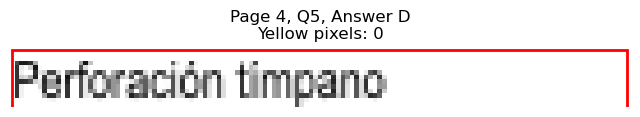


Page 4, Q5 - Selected Answer: A (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=112.9, y1=442.9
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 249
Page 4, Q6, A: Yellow percentage: 0.0%


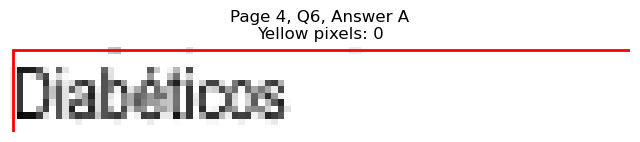

Page 4, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=163.6, y1=455.5
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 481
Page 4, Q6, B: Yellow percentage: 0.0%


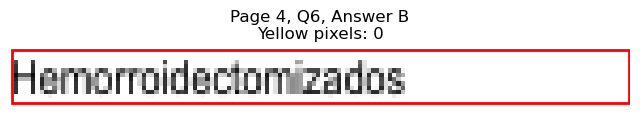

Page 4, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=417.8, y1=442.9
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 627
Page 4, Q6, C: Yellow percentage: 0.0%


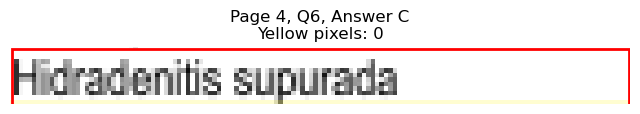

Page 4, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=368.7, y1=455.5
Page 4, Q6, D: Yellow pixels: 1024
Page 4, Q6, D: Total non-white pixels: 1288
Page 4, Q6, D: Yellow percentage: 79.5%


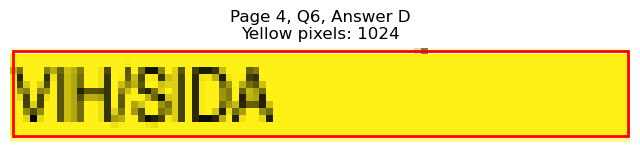


Page 4, Q6 - Selected Answer: D (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=150.5, y1=506.0
Page 4, Q7, A: Yellow pixels: 1404
Page 4, Q7, A: Total non-white pixels: 1729
Page 4, Q7, A: Yellow percentage: 81.2%


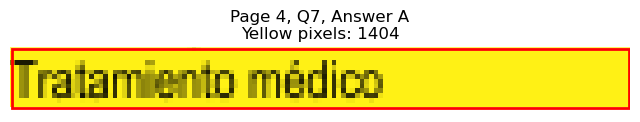

Page 4, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=181.1, y1=518.6
Page 4, Q7, B: Yellow pixels: 164
Page 4, Q7, B: Total non-white pixels: 712
Page 4, Q7, B: Yellow percentage: 23.0%


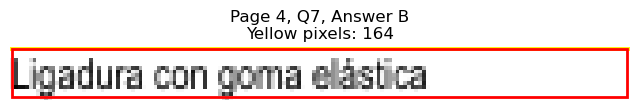

Page 4, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=387.8, y1=506.0
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 324
Page 4, Q7, C: Yellow percentage: 0.0%


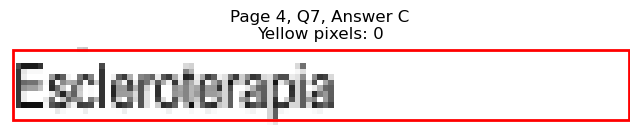

Page 4, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=363.7, y1=518.6
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 187
Page 4, Q7, D: Yellow percentage: 0.0%


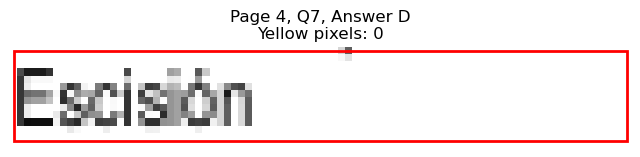


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=167.7, y1=581.8
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 658
Page 4, Q8, A: Yellow percentage: 0.0%


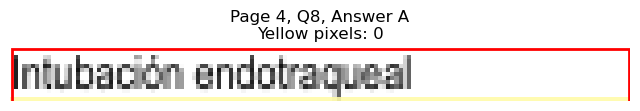

Page 4, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=179.2, y1=594.4
Page 4, Q8, B: Yellow pixels: 1540
Page 4, Q8, B: Total non-white pixels: 2268
Page 4, Q8, B: Yellow percentage: 67.9%


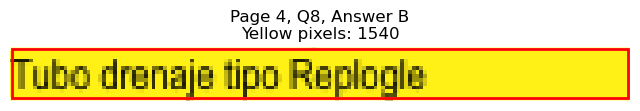

Page 4, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=415.3, y1=581.8
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 454
Page 4, Q8, C: Yellow percentage: 0.0%


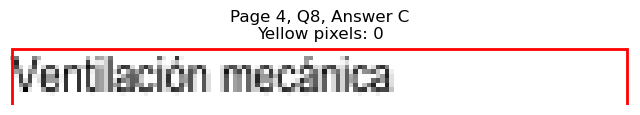

Page 4, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=431.8, y1=594.4
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 522
Page 4, Q8, D: Yellow percentage: 0.0%


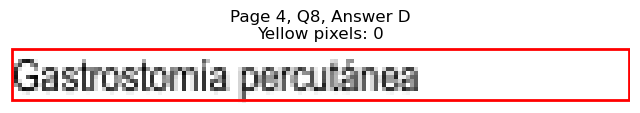


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=82.3, y1=632.3
Page 4, Q9, A: Yellow pixels: 65
Page 4, Q9, A: Total non-white pixels: 117
Page 4, Q9, A: Yellow percentage: 55.6%


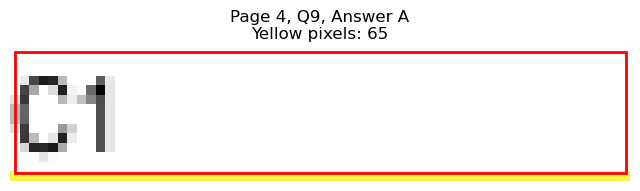

Page 4, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=82.3, y1=644.9
Page 4, Q9, B: Yellow pixels: 801
Page 4, Q9, B: Total non-white pixels: 845
Page 4, Q9, B: Yellow percentage: 94.8%


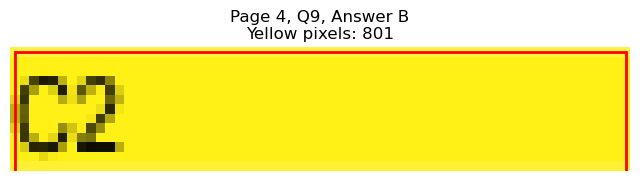

Page 4, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=341.6, y1=632.3
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 63
Page 4, Q9, C: Yellow percentage: 0.0%


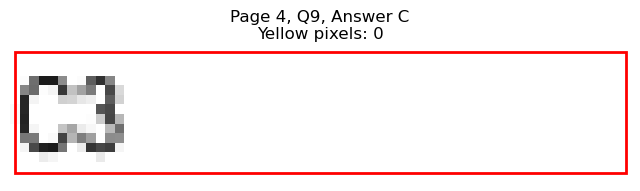

Page 4, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=341.6, y1=644.9
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 60
Page 4, Q9, D: Yellow percentage: 0.0%


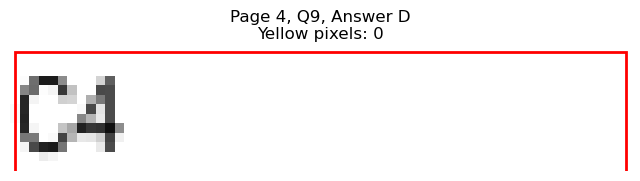


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=682.7, x1=127.0, y1=695.3
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 295
Page 4, Q10, A: Yellow percentage: 0.0%


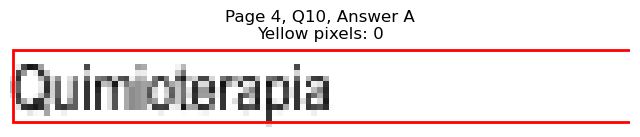

Page 4, Q10 - B: Detected box: x0=68.3, y0=695.4, x1=170.7, y1=708.0
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 529
Page 4, Q10, B: Yellow percentage: 0.0%


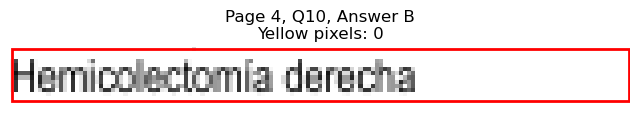

Page 4, Q10 - C: Detected box: x0=327.5, y0=682.7, x1=410.8, y1=695.3
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 429
Page 4, Q10, C: Yellow percentage: 0.0%


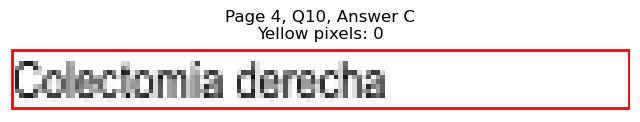

Page 4, Q10 - D: Detected box: x0=327.5, y0=695.4, x1=380.7, y1=708.0
Page 4, Q10, D: Yellow pixels: 1150
Page 4, Q10, D: Total non-white pixels: 1352
Page 4, Q10, D: Yellow percentage: 85.1%


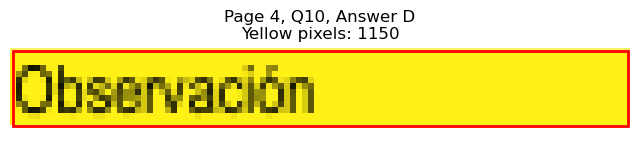


Page 4, Q10 - Selected Answer: D (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=139.9, x1=143.5, y1=152.6
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 362
Page 5, Q1, A: Yellow percentage: 0.0%


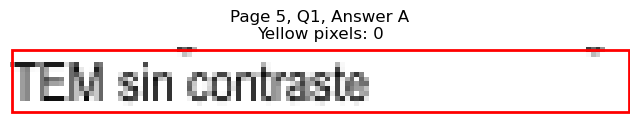

Page 5, Q1 - B: Detected box: x0=68.3, y0=152.5, x1=152.1, y1=165.2
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 412
Page 5, Q1, B: Yellow percentage: 0.0%


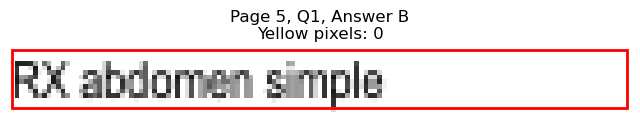

Page 5, Q1 - C: Detected box: x0=327.5, y0=139.9, x1=420.3, y1=152.6
Page 5, Q1, C: Yellow pixels: 144
Page 5, Q1, C: Total non-white pixels: 619
Page 5, Q1, C: Yellow percentage: 23.3%


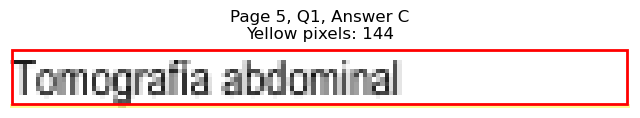

Page 5, Q1 - D: Detected box: x0=327.5, y0=152.5, x1=404.2, y1=165.2
Page 5, Q1, D: Yellow pixels: 1360
Page 5, Q1, D: Total non-white pixels: 1792
Page 5, Q1, D: Yellow percentage: 75.9%


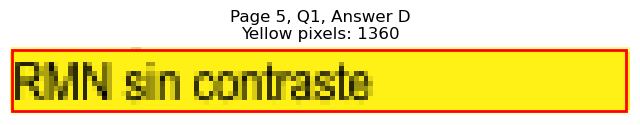


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=178.1, y1=203.0
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 505
Page 5, Q2, A: Yellow percentage: 0.0%


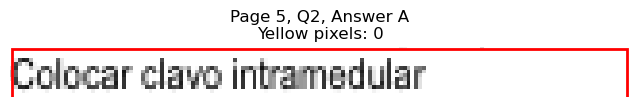

Page 5, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=160.6, y1=215.6
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 477
Page 5, Q2, B: Yellow percentage: 0.0%


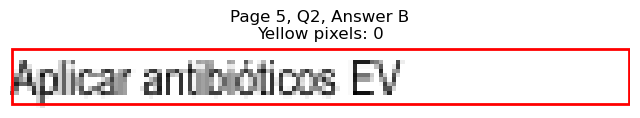

Page 5, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=429.9, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 677
Page 5, Q2, C: Yellow percentage: 0.0%


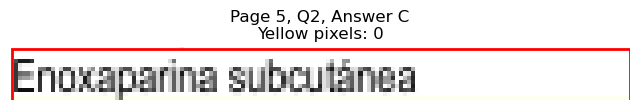

Page 5, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=434.3, y1=215.6
Page 5, Q2, D: Yellow pixels: 1609
Page 5, Q2, D: Total non-white pixels: 2212
Page 5, Q2, D: Yellow percentage: 72.7%


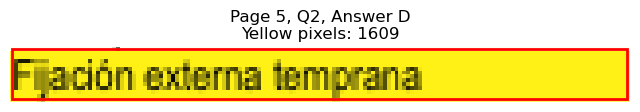


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=116.4, y1=253.5
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 237
Page 5, Q3, A: Yellow percentage: 0.0%


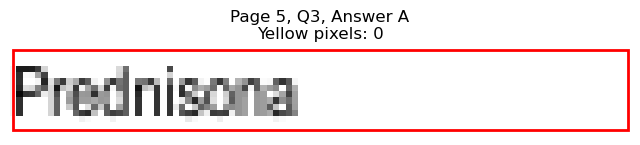

Page 5, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=123.0, y1=266.1
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 264
Page 5, Q3, B: Yellow percentage: 0.0%


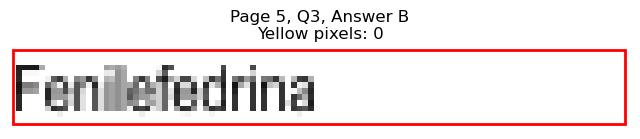

Page 5, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=391.3, y1=253.5
Page 5, Q3, C: Yellow pixels: 115
Page 5, Q3, C: Total non-white pixels: 459
Page 5, Q3, C: Yellow percentage: 25.1%


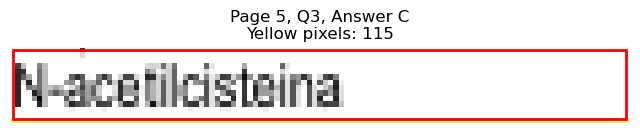

Page 5, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=409.7, y1=266.1
Page 5, Q3, D: Yellow pixels: 1413
Page 5, Q3, D: Total non-white pixels: 1862
Page 5, Q3, D: Yellow percentage: 75.9%


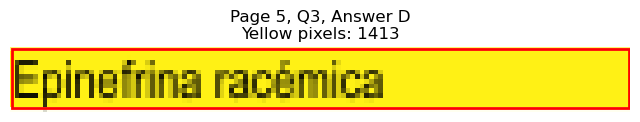


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=191.2, y1=329.3
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 614
Page 5, Q4, A: Yellow percentage: 0.0%


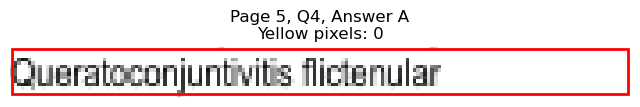

Page 5, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=169.6, y1=341.9
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 509
Page 5, Q4, B: Yellow percentage: 0.0%


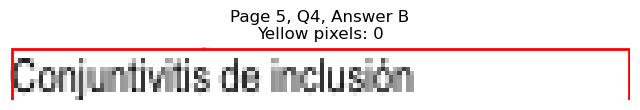

Page 5, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=450.9, y1=329.3
Page 5, Q4, C: Yellow pixels: 1607
Page 5, Q4, C: Total non-white pixels: 2436
Page 5, Q4, C: Yellow percentage: 66.0%


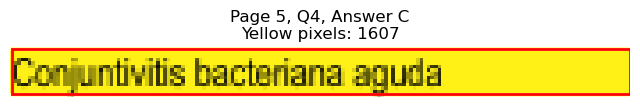

Page 5, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=452.9, y1=341.9
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 860
Page 5, Q4, D: Yellow percentage: 0.0%


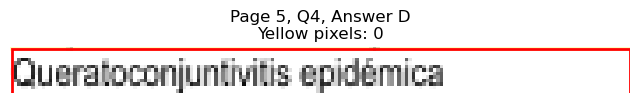


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=231.3, y1=405.0
Page 5, Q5, A: Yellow pixels: 2192
Page 5, Q5, A: Total non-white pixels: 2782
Page 5, Q5, A: Yellow percentage: 78.8%


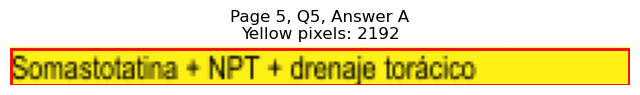

Page 5, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=303.0, y1=417.6
Page 5, Q5, B: Yellow pixels: 284
Page 5, Q5, B: Total non-white pixels: 1445
Page 5, Q5, B: Yellow percentage: 19.7%


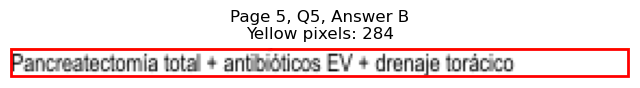

Page 5, Q5 - C: Detected box: x0=68.8, y0=417.6, x1=308.6, y1=430.3
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 1176
Page 5, Q5, C: Yellow percentage: 0.0%


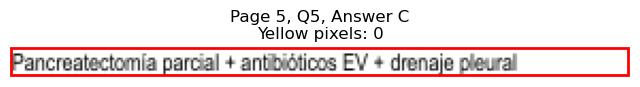

Page 5, Q5 - D: Detected box: x0=68.8, y0=430.2, x1=278.4, y1=442.9
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 1029
Page 5, Q5, D: Yellow percentage: 0.0%


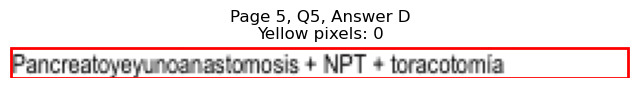


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=468.1, x1=102.9, y1=480.7
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 181
Page 5, Q6, A: Yellow percentage: 0.0%


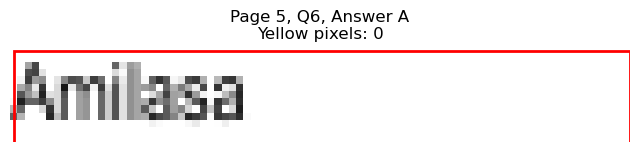

Page 5, Q6 - B: Detected box: x0=68.3, y0=480.8, x1=148.1, y1=493.4
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 376
Page 5, Q6, B: Yellow percentage: 0.0%


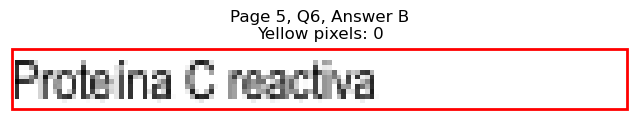

Page 5, Q6 - C: Detected box: x0=327.5, y0=468.1, x1=402.8, y1=480.7
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 395
Page 5, Q6, C: Yellow percentage: 0.0%


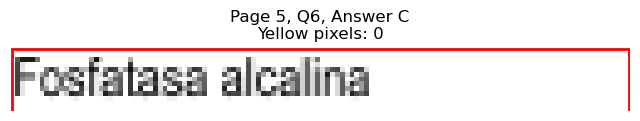

Page 5, Q6 - D: Detected box: x0=327.5, y0=480.8, x1=356.7, y1=493.4
Page 5, Q6, D: Yellow pixels: 863
Page 5, Q6, D: Total non-white pixels: 1120
Page 5, Q6, D: Yellow percentage: 77.1%


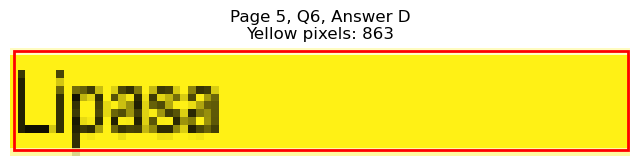


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=543.8, x1=162.6, y1=556.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 538
Page 5, Q7, A: Yellow percentage: 0.0%


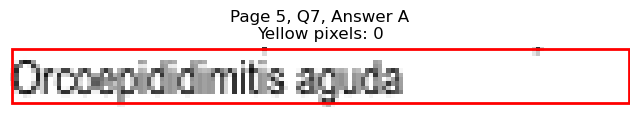

Page 5, Q7 - B: Detected box: x0=68.3, y0=556.5, x1=139.5, y1=569.2
Page 5, Q7, B: Yellow pixels: 1303
Page 5, Q7, B: Total non-white pixels: 1708
Page 5, Q7, B: Yellow percentage: 76.3%


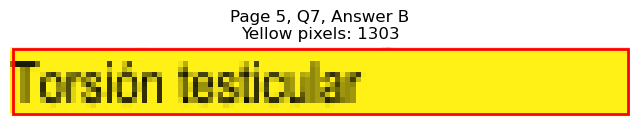

Page 5, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=399.8, y1=556.4
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 360
Page 5, Q7, C: Yellow percentage: 0.0%


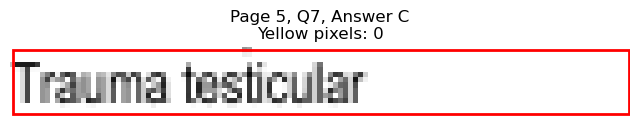

Page 5, Q7 - D: Detected box: x0=327.5, y0=556.5, x1=408.3, y1=569.2
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 414
Page 5, Q7, D: Yellow percentage: 0.0%


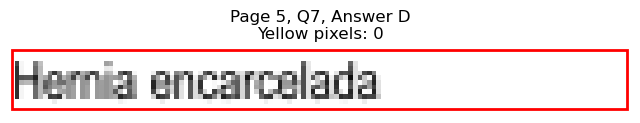


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=174.6, y1=632.3
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 567
Page 5, Q8, A: Yellow percentage: 0.0%


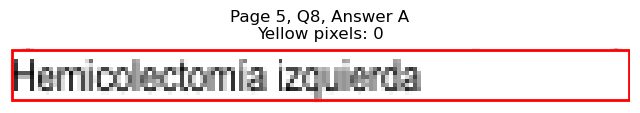

Page 5, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=160.1, y1=644.9
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 476
Page 5, Q8, B: Yellow percentage: 0.0%


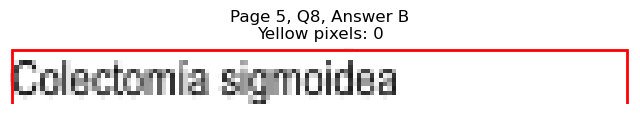

Page 5, Q8 - C: Detected box: x0=68.8, y0=644.9, x1=297.5, y1=657.5
Page 5, Q8, C: Yellow pixels: 280
Page 5, Q8, C: Total non-white pixels: 1393
Page 5, Q8, C: Yellow percentage: 20.1%


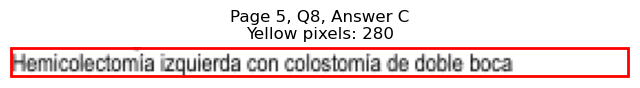

Page 5, Q8 - D: Detected box: x0=68.8, y0=657.5, x1=278.4, y1=670.1
Page 5, Q8, D: Yellow pixels: 2584
Page 5, Q8, D: Total non-white pixels: 3654
Page 5, Q8, D: Yellow percentage: 70.7%


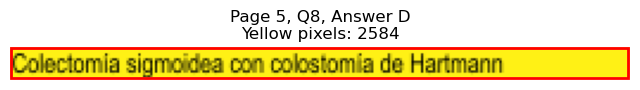


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=708.0, x1=152.1, y1=720.6
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 413
Page 5, Q9, A: Yellow percentage: 0.0%


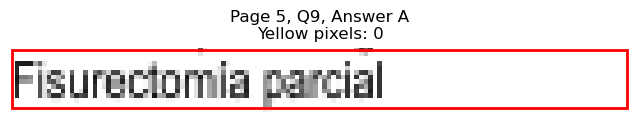

Page 5, Q9 - B: Detected box: x0=68.3, y0=720.6, x1=119.9, y1=733.2
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 272
Page 5, Q9, B: Yellow percentage: 0.0%


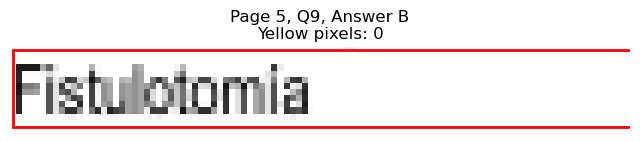

Page 5, Q9 - C: Detected box: x0=327.5, y0=708.0, x1=418.3, y1=720.6
Page 5, Q9, C: Yellow pixels: 1493
Page 5, Q9, C: Total non-white pixels: 1988
Page 5, Q9, C: Yellow percentage: 75.1%


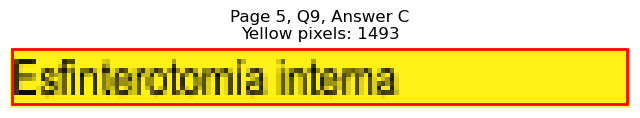

Page 5, Q9 - D: Detected box: x0=327.5, y0=720.6, x1=385.3, y1=733.2
Page 5, Q9, D: Yellow pixels: 109
Page 5, Q9, D: Total non-white pixels: 413
Page 5, Q9, D: Yellow percentage: 26.4%


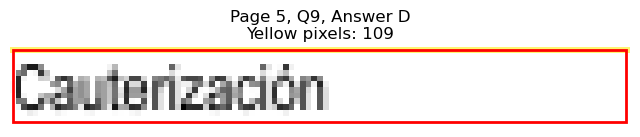


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=123.5, y1=114.7
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 385
Page 6, Q1, A: Yellow percentage: 0.0%


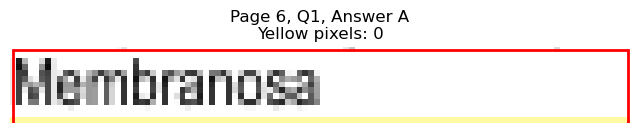

Page 6, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=113.9, y1=127.3
Page 6, Q1, B: Yellow pixels: 980
Page 6, Q1, B: Total non-white pixels: 1344
Page 6, Q1, B: Yellow percentage: 72.9%


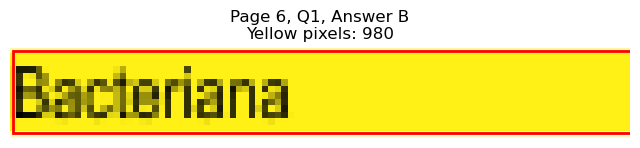

Page 6, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=362.7, y1=114.7
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 180
Page 6, Q1, C: Yellow percentage: 0.0%


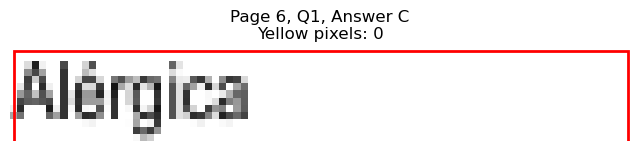

Page 6, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=353.1, y1=127.3
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 128
Page 6, Q1, D: Yellow percentage: 0.0%


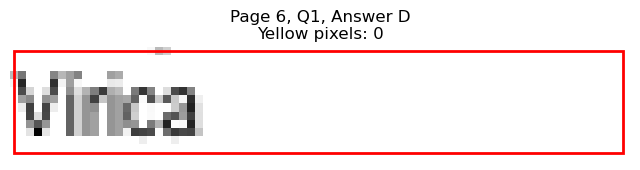


Page 6, Q1 - Selected Answer: B (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=172.6, y1=165.2
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 526
Page 6, Q2, A: Yellow percentage: 0.0%


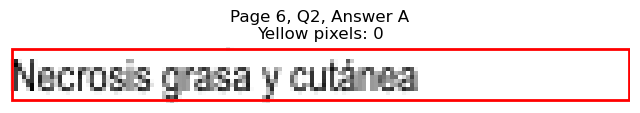

Page 6, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=169.6, y1=177.8
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 512
Page 6, Q2, B: Yellow percentage: 0.0%


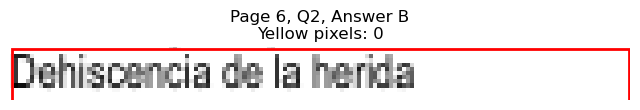

Page 6, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=506.6, y1=165.2
Page 6, Q2, C: Yellow pixels: 2074
Page 6, Q2, C: Total non-white pixels: 2996
Page 6, Q2, C: Yellow percentage: 69.2%


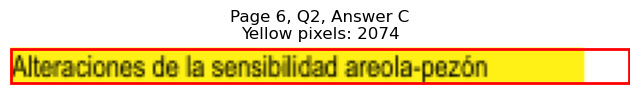

Page 6, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=361.6, y1=177.8
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 249
Page 6, Q2, D: Yellow percentage: 0.0%


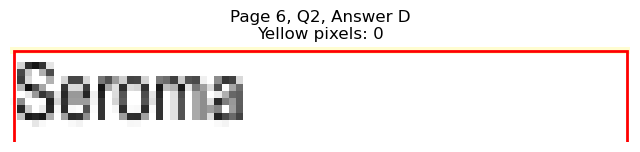


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=174.6, y1=240.9
Page 6, Q3, A: Yellow pixels: 1590
Page 6, Q3, A: Total non-white pixels: 2041
Page 6, Q3, A: Yellow percentage: 77.9%


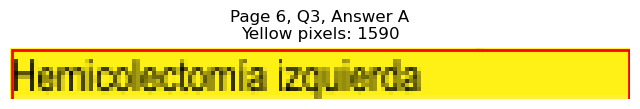

Page 6, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=135.5, y1=253.5
Page 6, Q3, B: Yellow pixels: 116
Page 6, Q3, B: Total non-white pixels: 493
Page 6, Q3, B: Yellow percentage: 23.5%


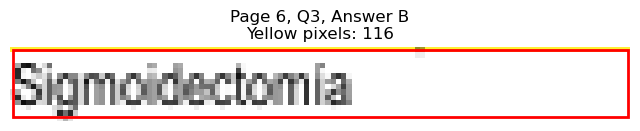

Page 6, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=434.8, y1=240.9
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 527
Page 6, Q3, C: Yellow percentage: 0.0%


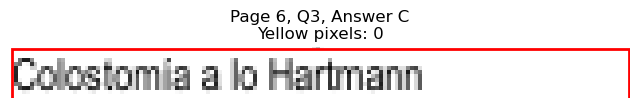

Page 6, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=452.0, y1=253.5
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 641
Page 6, Q3, D: Yellow percentage: 0.0%


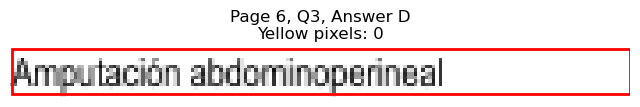


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=188.7, y1=304.1
Page 6, Q4, A: Yellow pixels: 1737
Page 6, Q4, A: Total non-white pixels: 2394
Page 6, Q4, A: Yellow percentage: 72.6%


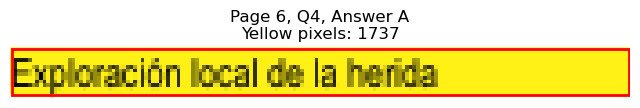

Page 6, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=171.1, y1=316.7
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 688
Page 6, Q4, B: Yellow percentage: 0.0%


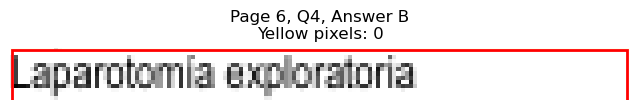

Page 6, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=432.9, y1=304.1
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 541
Page 6, Q4, C: Yellow percentage: 0.0%


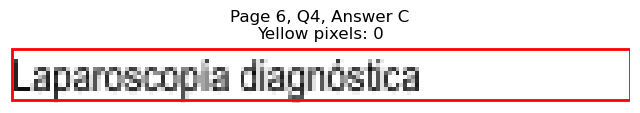

Page 6, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=477.1, y1=316.7
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 758
Page 6, Q4, D: Yellow percentage: 0.0%


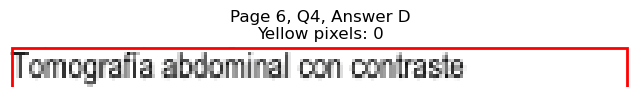


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=144.5, y1=367.2
Page 6, Q5, A: Yellow pixels: 1373
Page 6, Q5, A: Total non-white pixels: 1778
Page 6, Q5, A: Yellow percentage: 77.2%


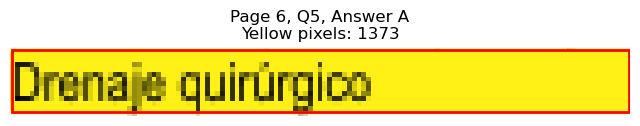

Page 6, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=183.6, y1=379.8
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 762
Page 6, Q5, B: Yellow percentage: 0.0%


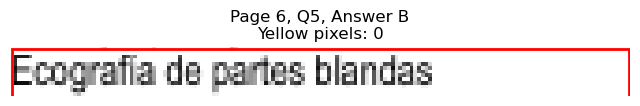

Page 6, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=415.9, y1=367.2
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 461
Page 6, Q5, C: Yellow percentage: 0.0%


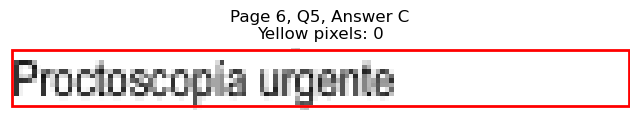

Page 6, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=425.8, y1=379.8
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 497
Page 6, Q5, D: Yellow percentage: 0.0%


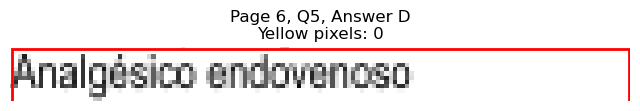


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=135.0, y1=442.9
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 340
Page 6, Q6, A: Yellow percentage: 0.0%


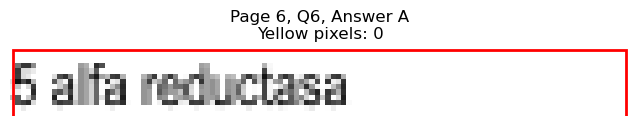

Page 6, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=185.2, y1=455.5
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 571
Page 6, Q6, B: Yellow percentage: 0.0%


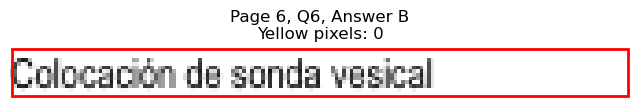

Page 6, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=420.3, y1=442.9
Page 6, Q6, C: Yellow pixels: 1521
Page 6, Q6, C: Total non-white pixels: 1872
Page 6, Q6, C: Yellow percentage: 81.2%


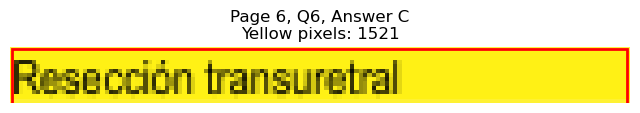

Page 6, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=419.8, y1=455.5
Page 6, Q6, D: Yellow pixels: 143
Page 6, Q6, D: Total non-white pixels: 630
Page 6, Q6, D: Yellow percentage: 22.7%


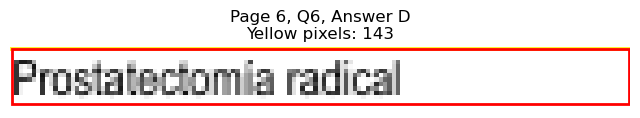


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=180.1, y1=518.6
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 554
Page 6, Q7, A: Yellow percentage: 0.0%


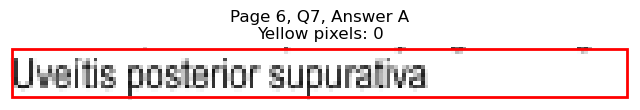

Page 6, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=216.3, y1=531.2
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 734
Page 6, Q7, B: Yellow percentage: 0.0%


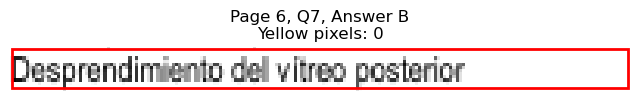

Page 6, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=467.0, y1=518.6
Page 6, Q7, C: Yellow pixels: 191
Page 6, Q7, C: Total non-white pixels: 909
Page 6, Q7, C: Yellow percentage: 21.0%


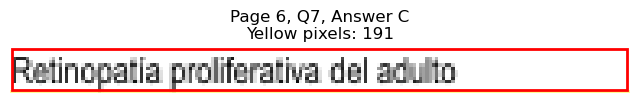

Page 6, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=485.5, y1=531.2
Page 6, Q7, D: Yellow pixels: 2121
Page 6, Q7, D: Total non-white pixels: 2926
Page 6, Q7, D: Yellow percentage: 72.5%


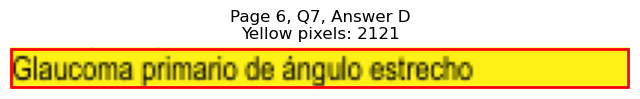


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=174.6, y1=569.2
Page 6, Q8, A: Yellow pixels: 1609
Page 6, Q8, A: Total non-white pixels: 2198
Page 6, Q8, A: Yellow percentage: 73.2%


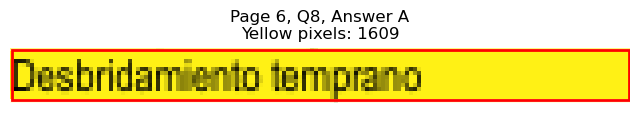

Page 6, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=131.5, y1=581.8
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 438
Page 6, Q8, B: Yellow percentage: 0.0%


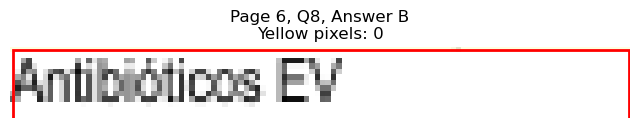

Page 6, Q8 - C: Detected box: x0=327.5, y0=228.3, x1=375.7, y1=240.9
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 495
Page 6, Q8, C: Yellow percentage: 0.0%


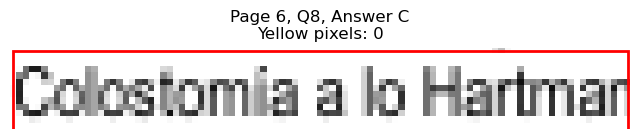

Page 6, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=387.2, y1=581.8
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 295
Page 6, Q8, D: Yellow percentage: 0.0%


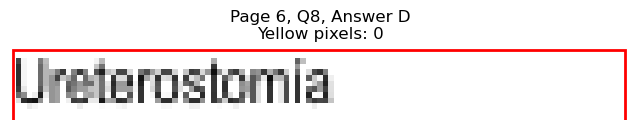


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=239.3, y1=632.3
Page 6, Q9, A: Yellow pixels: 1865
Page 6, Q9, A: Total non-white pixels: 2996
Page 6, Q9, A: Yellow percentage: 62.2%


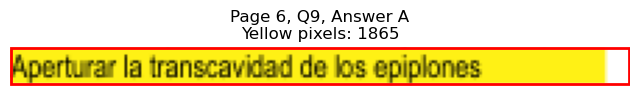

Page 6, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=166.1, y1=644.9
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 645
Page 6, Q9, B: Yellow percentage: 0.0%


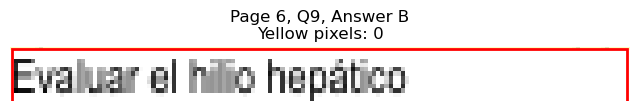

Page 6, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=407.8, y1=632.3
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 414
Page 6, Q9, C: Yellow percentage: 0.0%


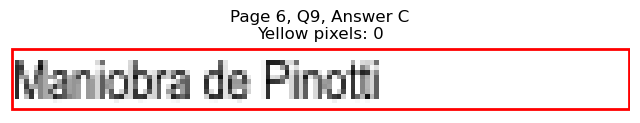

Page 6, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=414.8, y1=644.9
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 453
Page 6, Q9, D: Yellow percentage: 0.0%


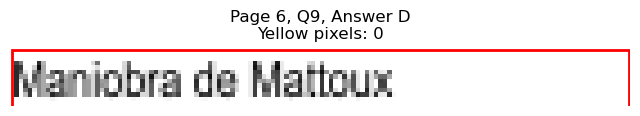


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=708.0, x1=151.1, y1=720.6
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 401
Page 6, Q10, A: Yellow percentage: 0.0%


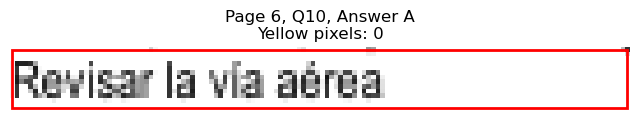

Page 6, Q10 - B: Detected box: x0=68.3, y0=720.6, x1=159.0, y1=733.2
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 456
Page 6, Q10, B: Yellow percentage: 0.0%


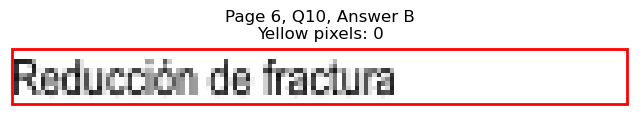

Page 6, Q10 - C: Detected box: x0=327.5, y0=708.0, x1=413.8, y1=720.6
Page 6, Q10, C: Yellow pixels: 1432
Page 6, Q10, C: Total non-white pixels: 1918
Page 6, Q10, C: Yellow percentage: 74.7%


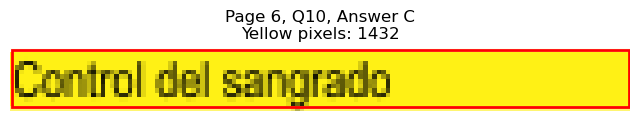

Page 6, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=397.7, y1=733.2
Page 6, Q10, D: Yellow pixels: 120
Page 6, Q10, D: Total non-white pixels: 481
Page 6, Q10, D: Yellow percentage: 24.9%


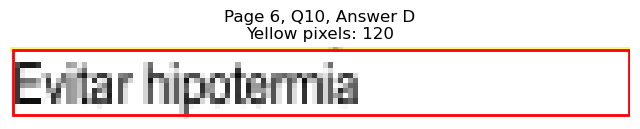


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=297.5, y1=127.3
Page 7, Q1, A: Yellow pixels: 2471
Page 7, Q1, A: Total non-white pixels: 3920
Page 7, Q1, A: Yellow percentage: 63.0%


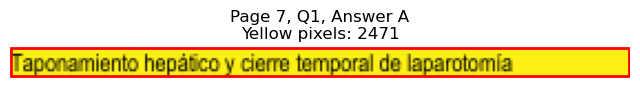

Page 7, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=234.3, y1=139.9
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 1083
Page 7, Q1, B: Yellow percentage: 0.0%


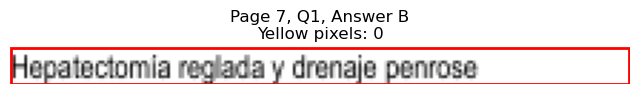

Page 7, Q1 - C: Detected box: x0=68.8, y0=139.9, x1=221.8, y1=152.6
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 812
Page 7, Q1, C: Yellow percentage: 0.0%


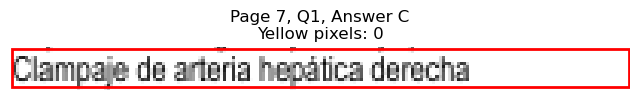

Page 7, Q1 - D: Detected box: x0=68.8, y0=152.5, x1=232.4, y1=165.2
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 803
Page 7, Q1, D: Yellow percentage: 0.0%


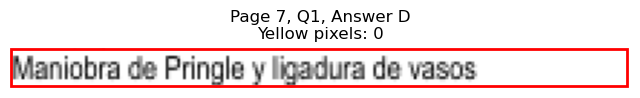


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=105.4, y1=203.0
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 219
Page 7, Q2, A: Yellow percentage: 0.0%


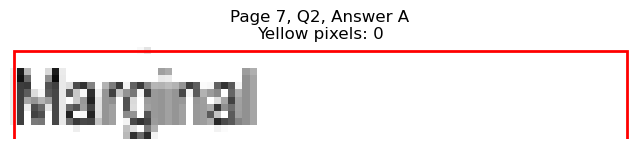

Page 7, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=98.4, y1=215.6
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 169
Page 7, Q2, B: Yellow percentage: 0.0%


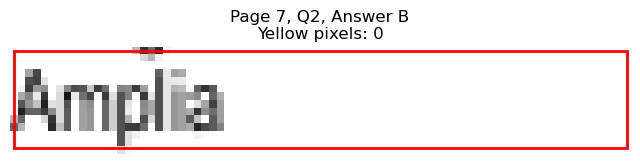

Page 7, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=378.7, y1=203.0
Page 7, Q2, C: Yellow pixels: 1106
Page 7, Q2, C: Total non-white pixels: 1326
Page 7, Q2, C: Yellow percentage: 83.4%


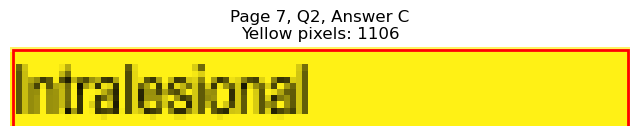

Page 7, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=360.2, y1=215.6
Page 7, Q2, D: Yellow pixels: 84
Page 7, Q2, D: Total non-white pixels: 264
Page 7, Q2, D: Yellow percentage: 31.8%


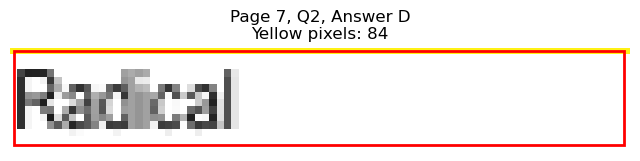


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=78.4, y1=266.1
Page 7, Q3, A: Yellow pixels: 761
Page 7, Q3, A: Total non-white pixels: 854
Page 7, Q3, A: Yellow percentage: 89.1%


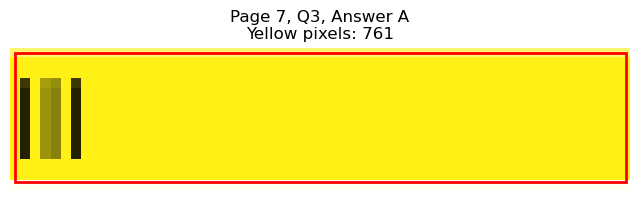

Page 7, Q3 - B: Detected box: x0=56.6, y0=266.1, x1=65.2, y1=278.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 110
Page 7, Q3, B: Yellow percentage: 0.0%


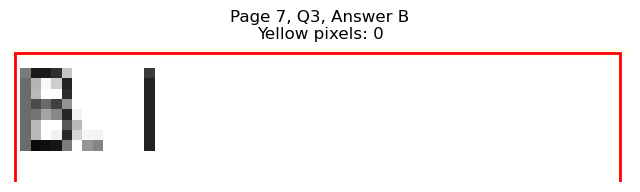

Page 7, Q3 - C: Detected box: x0=315.4, y0=253.5, x1=324.4, y1=266.1
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 70
Page 7, Q3, C: Yellow percentage: 0.0%


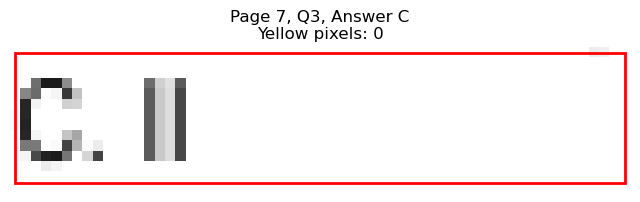

Page 7, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=338.6, y1=278.7
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 42
Page 7, Q3, D: Yellow percentage: 0.0%


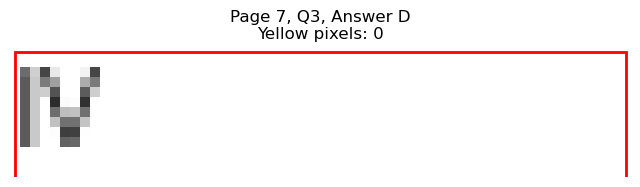


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=152.5, y1=316.7
Page 7, Q4, A: Yellow pixels: 6
Page 7, Q4, A: Total non-white pixels: 533
Page 7, Q4, A: Yellow percentage: 1.1%


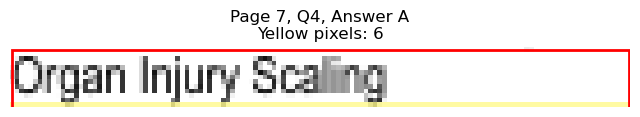

Page 7, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=109.0, y1=329.3
Page 7, Q4, B: Yellow pixels: 947
Page 7, Q4, B: Total non-white pixels: 1274
Page 7, Q4, B: Yellow percentage: 74.3%


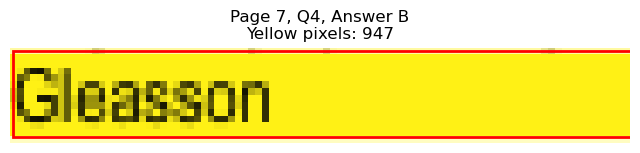

Page 7, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=360.2, y1=316.7
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 153
Page 7, Q4, C: Yellow percentage: 0.0%


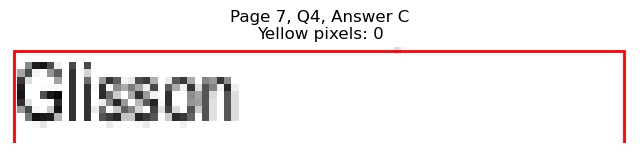

Page 7, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=372.7, y1=329.3
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 225
Page 7, Q4, D: Yellow percentage: 0.0%


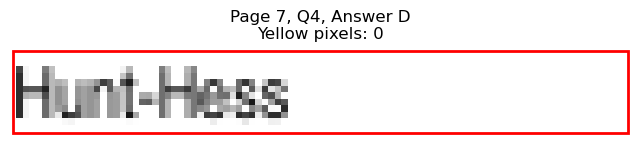


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=124.0, y1=392.4
Page 7, Q5, A: Yellow pixels: 1062
Page 7, Q5, A: Total non-white pixels: 1484
Page 7, Q5, A: Yellow percentage: 71.6%


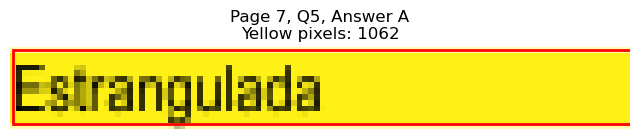

Page 7, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=114.5, y1=405.0
Page 7, Q5, B: Yellow pixels: 1
Page 7, Q5, B: Total non-white pixels: 330
Page 7, Q5, B: Yellow percentage: 0.3%


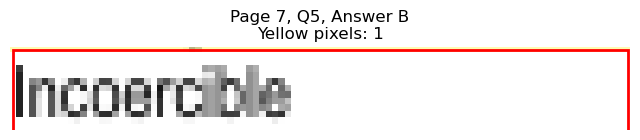

Page 7, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=377.7, y1=392.4
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 257
Page 7, Q5, C: Yellow percentage: 0.0%


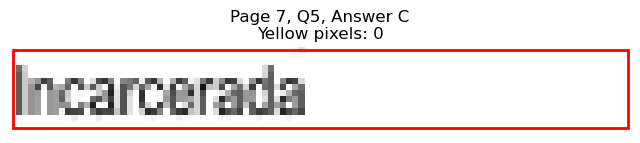

Page 7, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=369.7, y1=405.0
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 212
Page 7, Q5, D: Yellow percentage: 0.0%


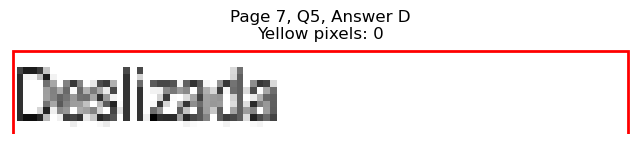


Page 7, Q5 - Selected Answer: A (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=120.5, y1=455.5
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 285
Page 7, Q6, A: Yellow percentage: 0.0%


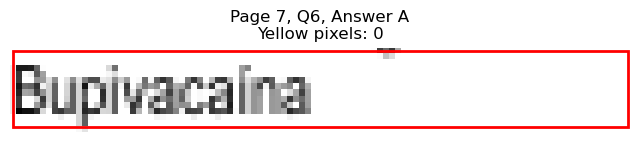

Page 7, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=121.0, y1=468.1
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 268
Page 7, Q6, B: Yellow percentage: 0.0%


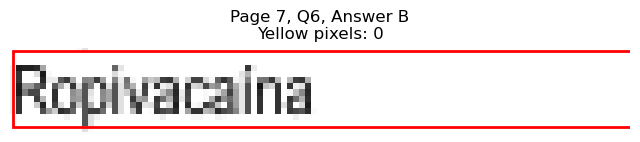

Page 7, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=373.6, y1=455.5
Page 7, Q6, C: Yellow pixels: 97
Page 7, Q6, C: Total non-white pixels: 342
Page 7, Q6, C: Yellow percentage: 28.4%


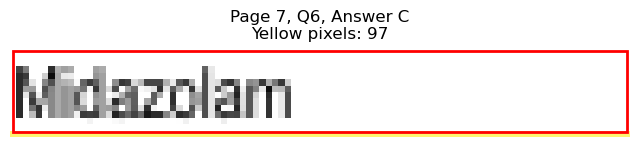

Page 7, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=369.2, y1=468.1
Page 7, Q6, D: Yellow pixels: 1070
Page 7, Q6, D: Total non-white pixels: 1302
Page 7, Q6, D: Yellow percentage: 82.2%


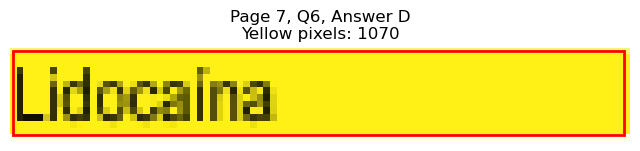


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=117.5, y1=531.2
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 235
Page 7, Q7, A: Yellow percentage: 0.0%


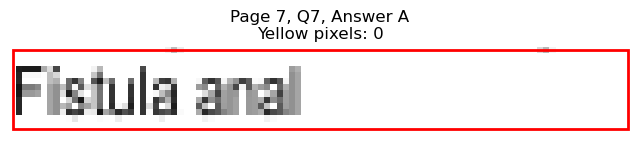

Page 7, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=159.6, y1=543.8
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 443
Page 7, Q7, B: Yellow percentage: 0.0%


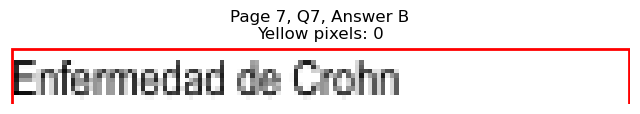

Page 7, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=381.2, y1=531.2
Page 7, Q7, C: Yellow pixels: 105
Page 7, Q7, C: Total non-white pixels: 384
Page 7, Q7, C: Yellow percentage: 27.3%


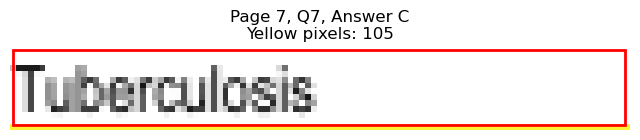

Page 7, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=374.8, y1=543.8
Page 7, Q7, D: Yellow pixels: 1101
Page 7, Q7, D: Total non-white pixels: 1274
Page 7, Q7, D: Yellow percentage: 86.4%


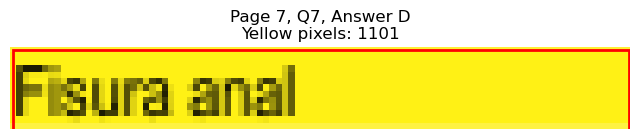


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=606.9, x1=153.6, y1=619.6
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 455
Page 7, Q8, A: Yellow percentage: 0.0%


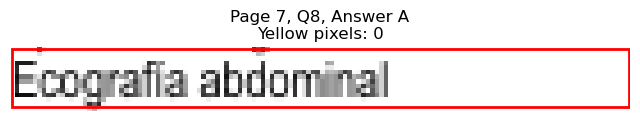

Page 7, Q8 - B: Detected box: x0=68.3, y0=619.6, x1=194.7, y1=632.3
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 617
Page 7, Q8, B: Yellow percentage: 0.0%


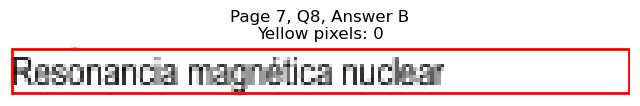

Page 7, Q8 - C: Detected box: x0=327.5, y0=606.9, x1=439.9, y1=619.6
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 563
Page 7, Q8, C: Yellow percentage: 0.0%


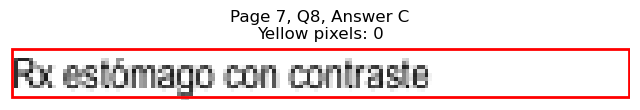

Page 7, Q8 - D: Detected box: x0=327.5, y0=619.6, x1=376.1, y1=632.3
Page 7, Q8, D: Yellow pixels: 1012
Page 7, Q8, D: Total non-white pixels: 1400
Page 7, Q8, D: Yellow percentage: 72.3%


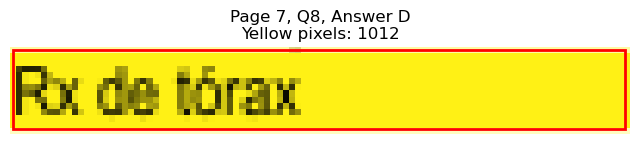


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=670.1, x1=153.0, y1=682.7
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 410
Page 7, Q9, A: Yellow percentage: 0.0%


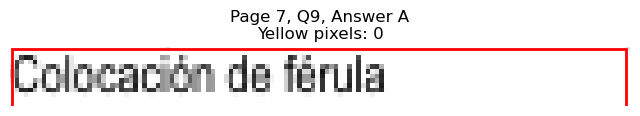

Page 7, Q9 - B: Detected box: x0=68.3, y0=682.7, x1=146.5, y1=695.3
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 399
Page 7, Q9, B: Yellow percentage: 0.0%


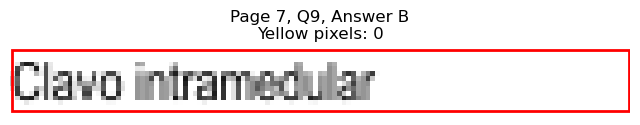

Page 7, Q9 - C: Detected box: x0=327.5, y0=670.1, x1=397.7, y1=682.7
Page 7, Q9, C: Yellow pixels: 1
Page 7, Q9, C: Total non-white pixels: 464
Page 7, Q9, C: Yellow percentage: 0.2%


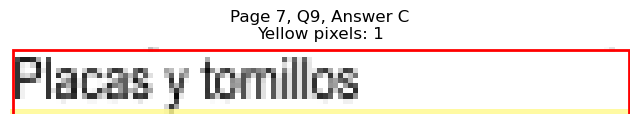

Page 7, Q9 - D: Detected box: x0=327.5, y0=682.7, x1=393.8, y1=695.3
Page 7, Q9, D: Yellow pixels: 1136
Page 7, Q9, D: Total non-white pixels: 1638
Page 7, Q9, D: Yellow percentage: 69.4%


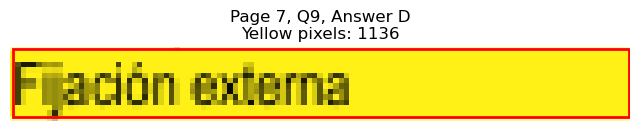


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=321.6, y1=733.2
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 1296
Page 7, Q10, A: Yellow percentage: 0.0%


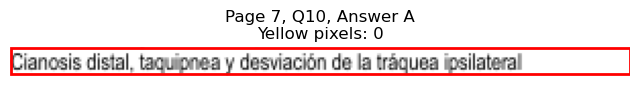

Page 7, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=274.8, y1=745.8
Page 7, Q10, B: Yellow pixels: 1
Page 7, Q10, B: Total non-white pixels: 1243
Page 7, Q10, B: Yellow percentage: 0.1%


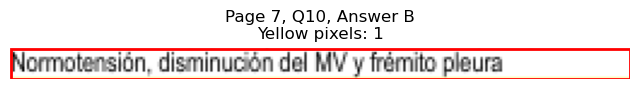

Page 7, Q10 - C: Detected box: x0=68.8, y0=745.8, x1=334.7, y1=758.4
Page 7, Q10, C: Yellow pixels: 3057
Page 7, Q10, C: Total non-white pixels: 4438
Page 7, Q10, C: Yellow percentage: 68.9%


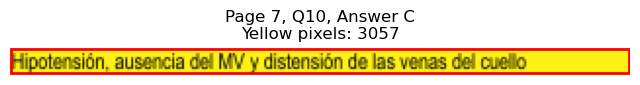

Page 7, Q10 - D: Detected box: x0=68.8, y0=758.5, x1=334.2, y1=771.2
Page 7, Q10, D: Yellow pixels: 316
Page 7, Q10, D: Total non-white pixels: 1616
Page 7, Q10, D: Yellow percentage: 19.6%


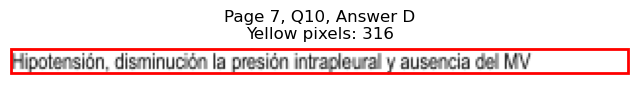


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=154.1, y1=127.3
Page 8, Q1, A: Yellow pixels: 1306
Page 8, Q1, A: Total non-white pixels: 1918
Page 8, Q1, A: Yellow percentage: 68.1%


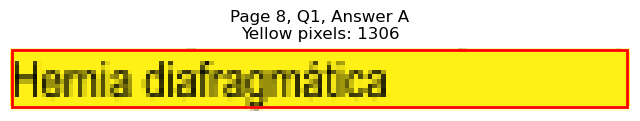

Page 8, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=140.1, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 495
Page 8, Q1, B: Yellow percentage: 0.0%


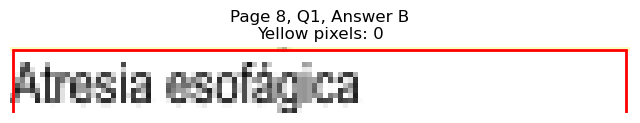

Page 8, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=412.9, y1=127.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 434
Page 8, Q1, C: Yellow percentage: 0.0%


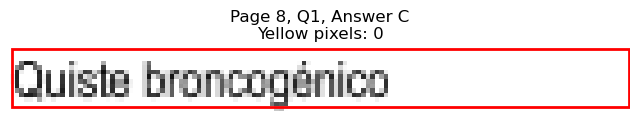

Page 8, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=438.9, y1=139.9
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 573
Page 8, Q1, D: Yellow percentage: 0.0%


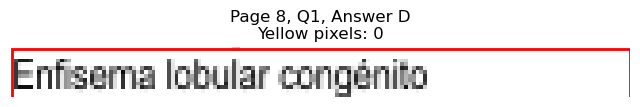


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=95.4, y1=203.0
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 127
Page 8, Q2, A: Yellow percentage: 0.0%


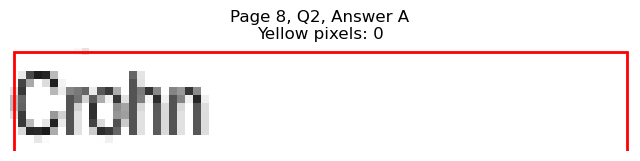

Page 8, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=85.8, y1=215.6
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 72
Page 8, Q2, B: Yellow percentage: 0.0%


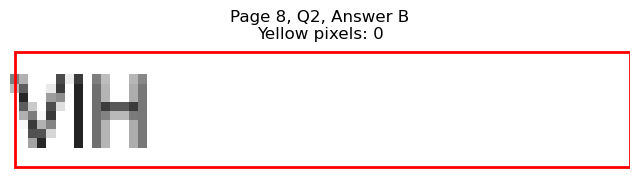

Page 8, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=375.2, y1=203.0
Page 8, Q2, C: Yellow pixels: 1095
Page 8, Q2, C: Total non-white pixels: 1287
Page 8, Q2, C: Yellow percentage: 85.1%


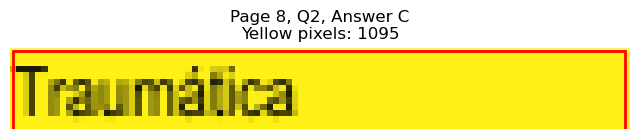

Page 8, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=381.2, y1=215.6
Page 8, Q2, D: Yellow pixels: 105
Page 8, Q2, D: Total non-white pixels: 384
Page 8, Q2, D: Yellow percentage: 27.3%


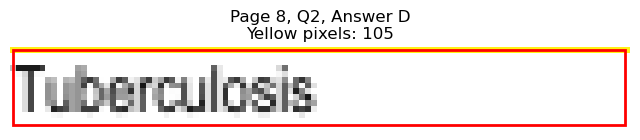


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=171.1, y1=291.5
Page 8, Q3, A: Yellow pixels: 1604
Page 8, Q3, A: Total non-white pixels: 2156
Page 8, Q3, A: Yellow percentage: 74.4%


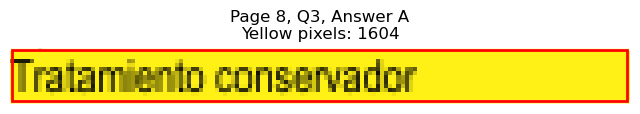

Page 8, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=171.1, y1=304.1
Page 8, Q3, B: Yellow pixels: 154
Page 8, Q3, B: Total non-white pixels: 692
Page 8, Q3, B: Yellow percentage: 22.3%


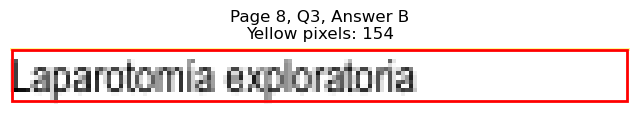

Page 8, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=432.9, y1=291.5
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 541
Page 8, Q3, C: Yellow percentage: 0.0%


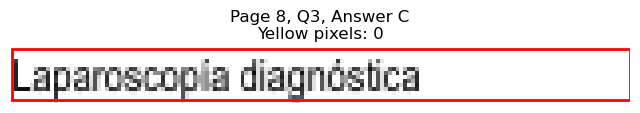

Page 8, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=398.8, y1=304.1
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 357
Page 8, Q3, D: Yellow percentage: 0.0%


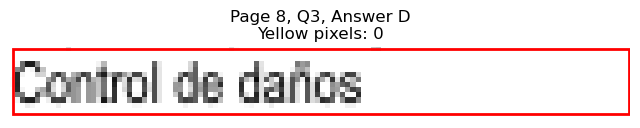


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=151.6, y1=379.8
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 541
Page 8, Q4, A: Yellow percentage: 0.0%


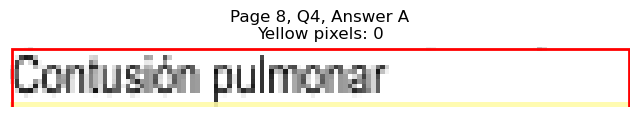

Page 8, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=133.0, y1=392.4
Page 8, Q4, B: Yellow pixels: 1138
Page 8, Q4, B: Total non-white pixels: 1610
Page 8, Q4, B: Yellow percentage: 70.7%


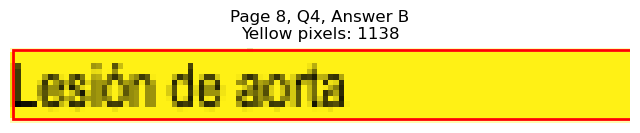

Page 8, Q4 - C: Detected box: x0=327.5, y0=367.1, x1=423.3, y1=379.8
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 490
Page 8, Q4, C: Yellow percentage: 0.0%


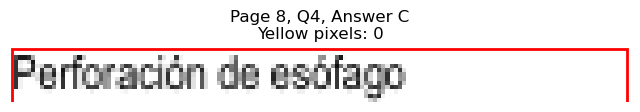

Page 8, Q4 - D: Detected box: x0=327.5, y0=379.7, x1=374.3, y1=392.4
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 236
Page 8, Q4, D: Yellow percentage: 0.0%


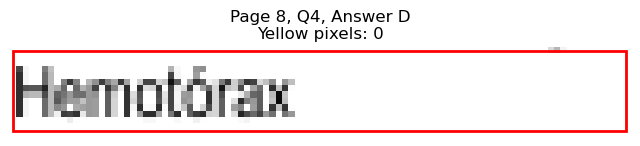


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=430.2, x1=143.1, y1=442.9
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 457
Page 8, Q5, A: Yellow percentage: 0.0%


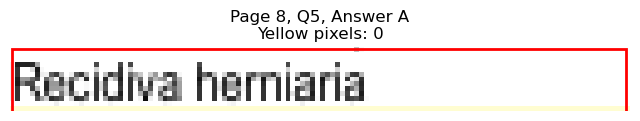

Page 8, Q5 - B: Detected box: x0=68.3, y0=442.8, x1=145.0, y1=455.5
Page 8, Q5, B: Yellow pixels: 1356
Page 8, Q5, B: Total non-white pixels: 1778
Page 8, Q5, B: Yellow percentage: 76.3%


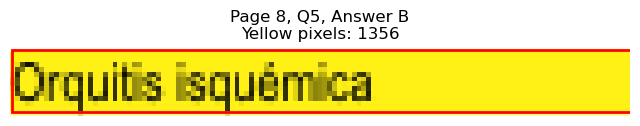

Page 8, Q5 - C: Detected box: x0=327.5, y0=430.2, x1=413.3, y1=442.9
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 434
Page 8, Q5, C: Yellow percentage: 0.0%


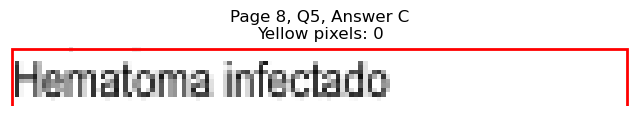

Page 8, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=368.2, y1=455.5
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 219
Page 8, Q5, D: Yellow percentage: 0.0%


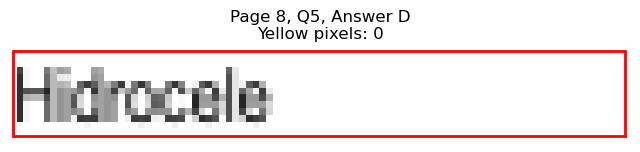


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=518.6, x1=112.5, y1=531.2
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 237
Page 8, Q6, A: Yellow percentage: 0.0%


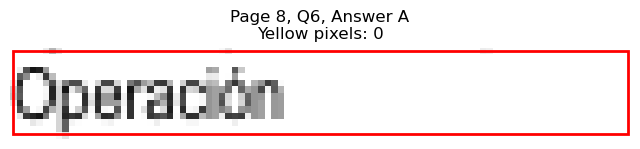

Page 8, Q6 - B: Detected box: x0=68.3, y0=531.2, x1=150.0, y1=543.8
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 417
Page 8, Q6, B: Yellow percentage: 0.0%


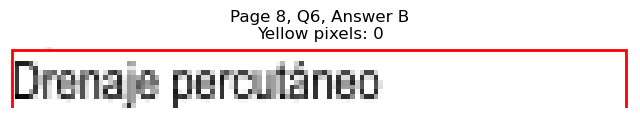

Page 8, Q6 - C: Detected box: x0=327.5, y0=518.6, x1=380.7, y1=531.2
Page 8, Q6, C: Yellow pixels: 1150
Page 8, Q6, C: Total non-white pixels: 1456
Page 8, Q6, C: Yellow percentage: 79.0%


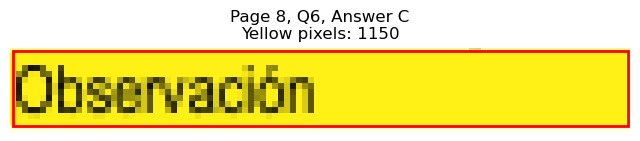

Page 8, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=403.7, y1=543.8
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 532
Page 8, Q6, D: Yellow percentage: 0.0%


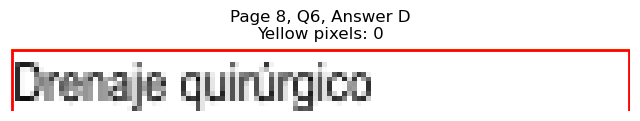


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=102.4, y1=581.8
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 168
Page 8, Q7, A: Yellow percentage: 0.0%


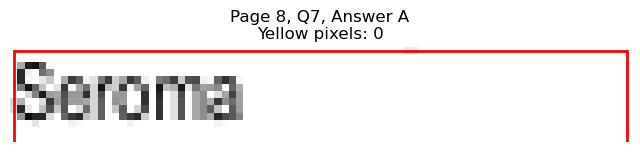

Page 8, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=155.5, y1=594.4
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 434
Page 8, Q7, B: Yellow percentage: 0.0%


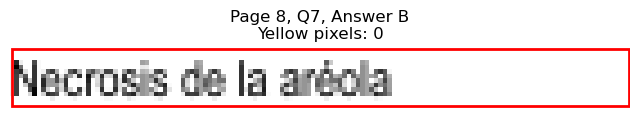

Page 8, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=366.2, y1=581.8
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 290
Page 8, Q7, C: Yellow percentage: 0.0%


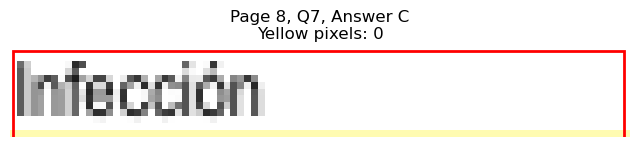

Page 8, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=374.2, y1=594.4
Page 8, Q7, D: Yellow pixels: 990
Page 8, Q7, D: Total non-white pixels: 1372
Page 8, Q7, D: Yellow percentage: 72.2%


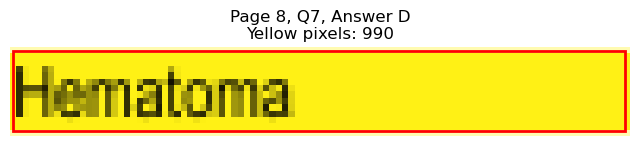


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=212.7, y1=632.3
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 747
Page 8, Q8, A: Yellow percentage: 0.0%


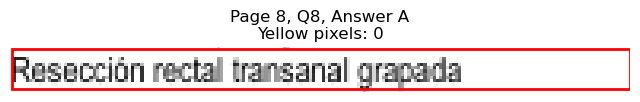

Page 8, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=200.7, y1=644.9
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 639
Page 8, Q8, B: Yellow percentage: 0.0%


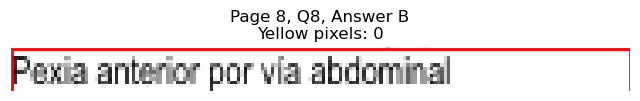

Page 8, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=436.9, y1=632.3
Page 8, Q8, C: Yellow pixels: 1506
Page 8, Q8, C: Total non-white pixels: 2240
Page 8, Q8, C: Yellow percentage: 67.2%


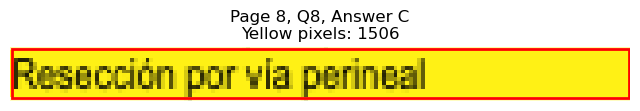

Page 8, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=505.7, y1=644.9
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 1083
Page 8, Q8, D: Yellow percentage: 0.0%


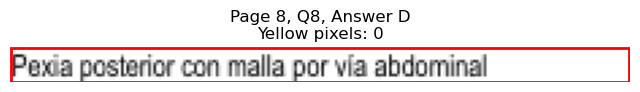


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=682.7, x1=86.9, y1=695.3
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 86
Page 8, Q9, A: Yellow percentage: 0.0%


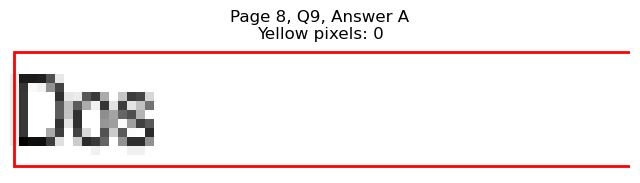

Page 8, Q9 - B: Detected box: x0=68.3, y0=695.4, x1=93.9, y1=708.0
Page 8, Q9, B: Yellow pixels: 911
Page 8, Q9, B: Total non-white pixels: 988
Page 8, Q9, B: Yellow percentage: 92.2%


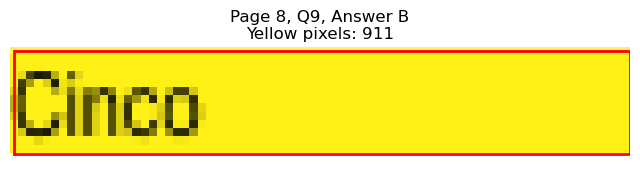

Page 8, Q9 - C: Detected box: x0=327.5, y0=682.7, x1=348.1, y1=695.3
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 91
Page 8, Q9, C: Yellow percentage: 0.0%


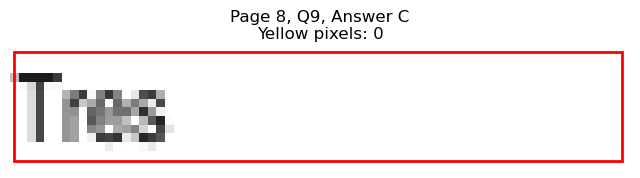

Page 8, Q9 - D: Detected box: x0=327.5, y0=695.4, x1=356.1, y1=708.0
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 138
Page 8, Q9, D: Yellow percentage: 0.0%


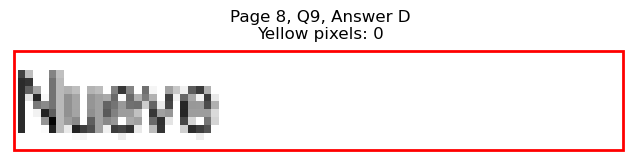


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=745.8, x1=174.6, y1=758.4
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 532
Page 8, Q10, A: Yellow percentage: 0.0%


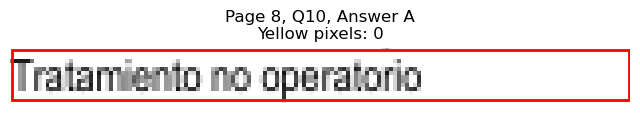

Page 8, Q10 - B: Detected box: x0=68.3, y0=758.5, x1=171.6, y1=771.2
Page 8, Q10, B: Yellow pixels: 1582
Page 8, Q10, B: Total non-white pixels: 2156
Page 8, Q10, B: Yellow percentage: 73.4%


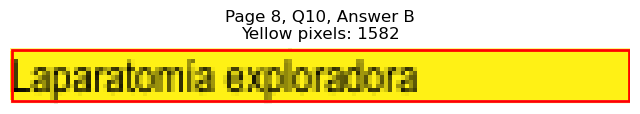

Page 8, Q10 - C: Detected box: x0=327.5, y0=745.8, x1=347.6, y1=758.4
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 80
Page 8, Q10, C: Yellow percentage: 0.0%


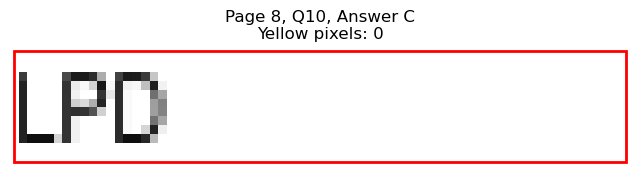

Page 8, Q10 - D: Detected box: x0=327.5, y0=758.5, x1=382.3, y1=771.2
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 278
Page 8, Q10, D: Yellow percentage: 0.0%


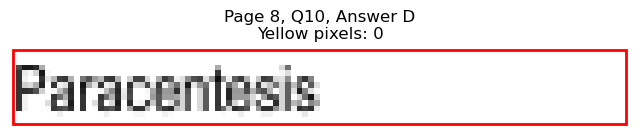


Page 8, Q10 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=139.9, x1=157.1, y1=152.6
Page 9, Q1, A: Yellow pixels: 140
Page 9, Q1, A: Total non-white pixels: 592
Page 9, Q1, A: Yellow percentage: 23.6%


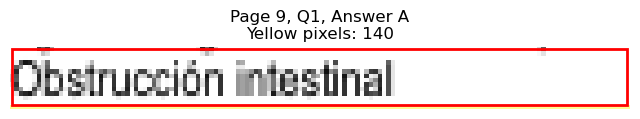

Page 9, Q1 - B: Detected box: x0=68.3, y0=152.5, x1=190.2, y1=165.2
Page 9, Q1, B: Yellow pixels: 1768
Page 9, Q1, B: Total non-white pixels: 2422
Page 9, Q1, B: Yellow percentage: 73.0%


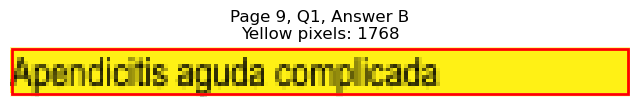

Page 9, Q1 - C: Detected box: x0=327.5, y0=139.9, x1=453.9, y1=152.6
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 689
Page 9, Q1, C: Yellow percentage: 0.0%


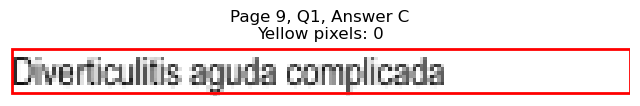

Page 9, Q1 - D: Detected box: x0=327.5, y0=152.5, x1=429.9, y1=165.2
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 534
Page 9, Q1, D: Yellow percentage: 0.0%


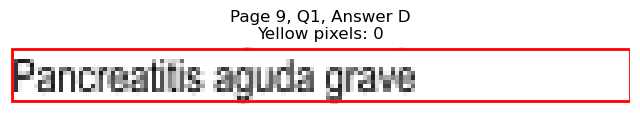


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=228.3, x1=138.5, y1=240.9
Page 9, Q2, A: Yellow pixels: 1294
Page 9, Q2, A: Total non-white pixels: 1573
Page 9, Q2, A: Yellow percentage: 82.3%


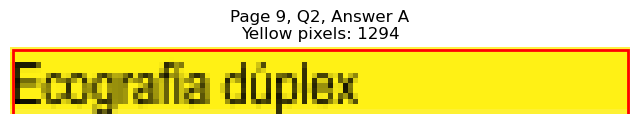

Page 9, Q2 - B: Detected box: x0=68.3, y0=240.9, x1=117.0, y1=253.5
Page 9, Q2, B: Yellow pixels: 95
Page 9, Q2, B: Total non-white pixels: 368
Page 9, Q2, B: Yellow percentage: 25.8%


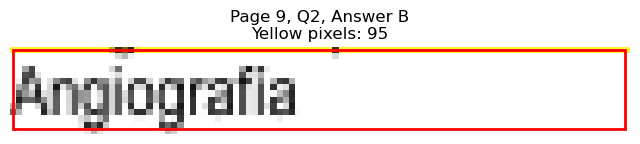

Page 9, Q2 - C: Detected box: x0=327.5, y0=228.3, x1=397.3, y1=240.9
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 365
Page 9, Q2, C: Yellow percentage: 0.0%


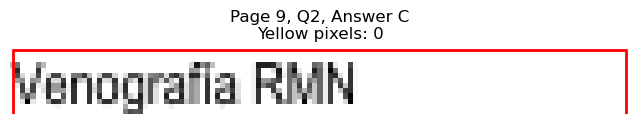

Page 9, Q2 - D: Detected box: x0=327.5, y0=240.9, x1=423.9, y1=253.5
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 487
Page 9, Q2, D: Yellow percentage: 0.0%


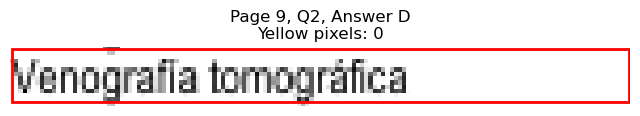


Page 9, Q2 - Selected Answer: A (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=126.5, y1=291.5
Page 9, Q3, A: Yellow pixels: 109
Page 9, Q3, A: Total non-white pixels: 404
Page 9, Q3, A: Yellow percentage: 27.0%


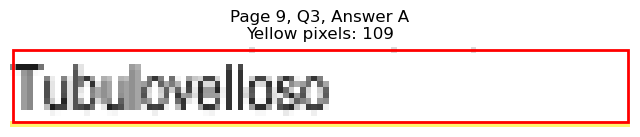

Page 9, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=100.5, y1=304.1
Page 9, Q3, B: Yellow pixels: 946
Page 9, Q3, B: Total non-white pixels: 1162
Page 9, Q3, B: Yellow percentage: 81.4%


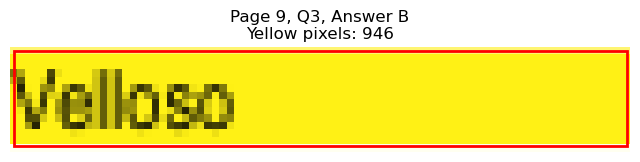

Page 9, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=360.7, y1=291.5
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 166
Page 9, Q3, C: Yellow percentage: 0.0%


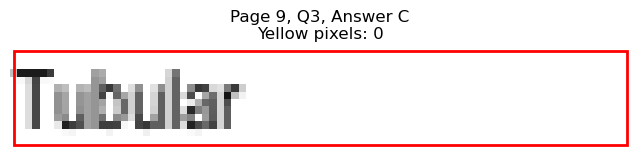

Page 9, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=376.1, y1=304.1
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 264
Page 9, Q3, D: Yellow percentage: 0.0%


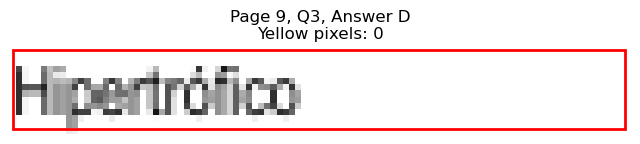


Page 9, Q3 - Selected Answer: B (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=65.2, y1=354.6
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 67
Page 9, Q4, A: Yellow percentage: 0.0%


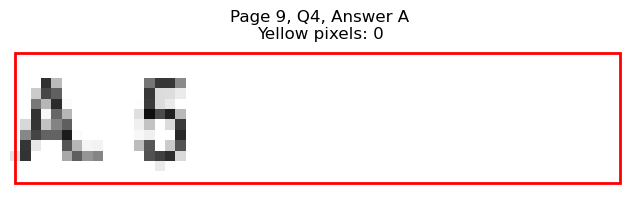

Page 9, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=80.9, y1=367.2
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 60
Page 9, Q4, B: Yellow percentage: 0.0%


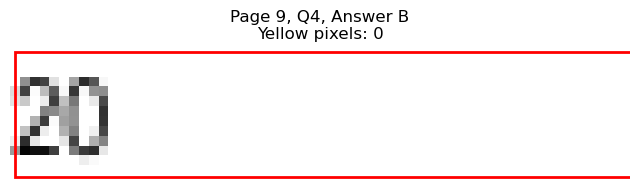

Page 9, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=324.4, y1=354.6
Page 9, Q4, C: Yellow pixels: 60
Page 9, Q4, C: Total non-white pixels: 118
Page 9, Q4, C: Yellow percentage: 50.8%


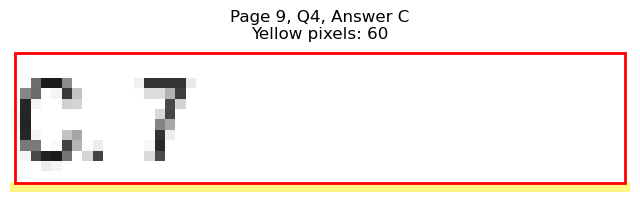

Page 9, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=340.1, y1=367.2
Page 9, Q4, D: Yellow pixels: 801
Page 9, Q4, D: Total non-white pixels: 896
Page 9, Q4, D: Yellow percentage: 89.4%


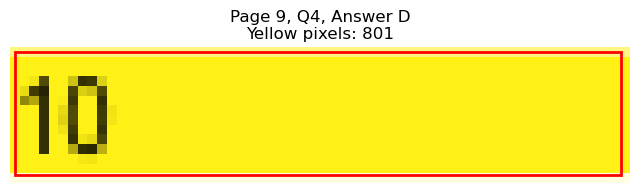


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=106.9, y1=405.0
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 193
Page 9, Q5, A: Yellow percentage: 0.0%


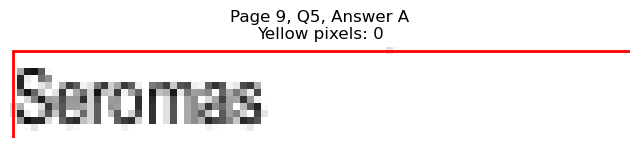

Page 9, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=119.4, y1=417.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 258
Page 9, Q5, B: Yellow percentage: 0.0%


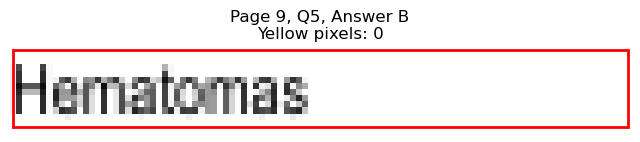

Page 9, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=442.4, y1=405.0
Page 9, Q5, C: Yellow pixels: 1672
Page 9, Q5, C: Total non-white pixels: 2158
Page 9, Q5, C: Yellow percentage: 77.5%


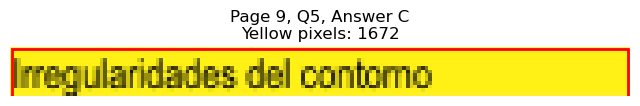

Page 9, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=424.9, y1=417.6
Page 9, Q5, D: Yellow pixels: 144
Page 9, Q5, D: Total non-white pixels: 627
Page 9, Q5, D: Yellow percentage: 23.0%


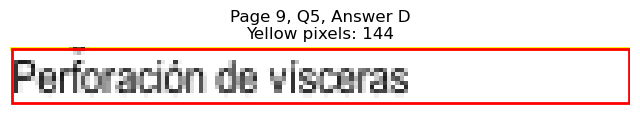


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=130.5, y1=455.5
Page 9, Q6, A: Yellow pixels: 113
Page 9, Q6, A: Total non-white pixels: 451
Page 9, Q6, A: Yellow percentage: 25.1%


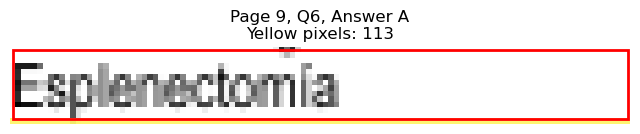

Page 9, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=114.4, y1=468.1
Page 9, Q6, B: Yellow pixels: 1071
Page 9, Q6, B: Total non-white pixels: 1358
Page 9, Q6, B: Yellow percentage: 78.9%


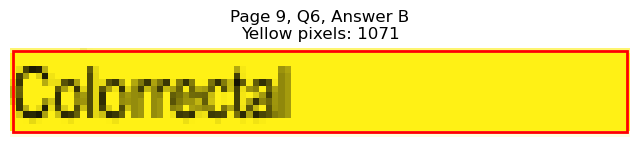

Page 9, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=439.9, y1=455.5
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 583
Page 9, Q6, C: Yellow percentage: 0.0%


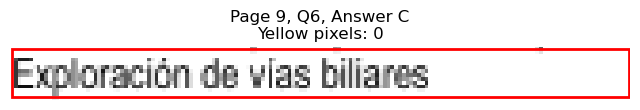

Page 9, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=403.7, y1=468.1
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 369
Page 9, Q6, D: Yellow percentage: 0.0%


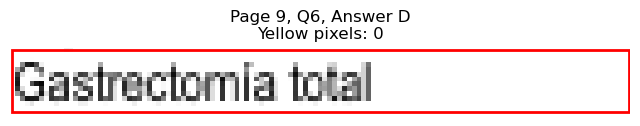


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=148.6, y1=543.8
Page 9, Q7, A: Yellow pixels: 1372
Page 9, Q7, A: Total non-white pixels: 1703
Page 9, Q7, A: Yellow percentage: 80.6%


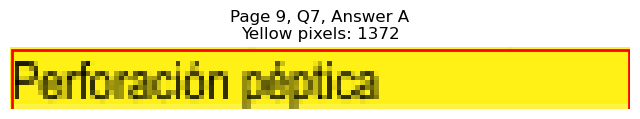

Page 9, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=145.6, y1=556.4
Page 9, Q7, B: Yellow pixels: 124
Page 9, Q7, B: Total non-white pixels: 552
Page 9, Q7, B: Yellow percentage: 22.5%


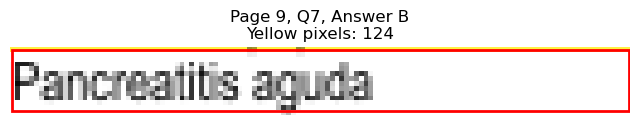

Page 9, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=426.3, y1=543.8
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 539
Page 9, Q7, C: Yellow percentage: 0.0%


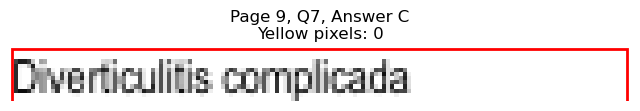

Page 9, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=449.5, y1=556.4
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 632
Page 9, Q7, D: Yellow percentage: 0.0%


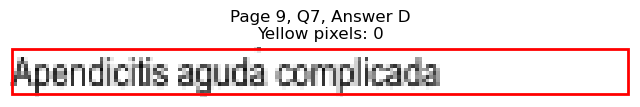


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=145.6, y1=594.4
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 381
Page 9, Q8, A: Yellow percentage: 0.0%


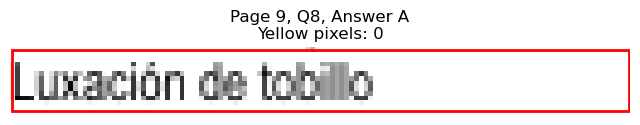

Page 9, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=151.7, y1=607.0
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 383
Page 9, Q8, B: Yellow percentage: 0.0%


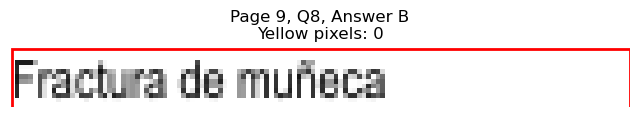

Page 9, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=405.3, y1=594.4
Page 9, Q8, C: Yellow pixels: 1287
Page 9, Q8, C: Total non-white pixels: 1806
Page 9, Q8, C: Yellow percentage: 71.3%


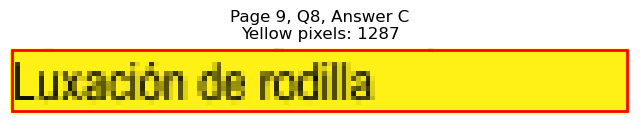

Page 9, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=433.4, y1=607.0
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 699
Page 9, Q8, D: Yellow percentage: 0.0%


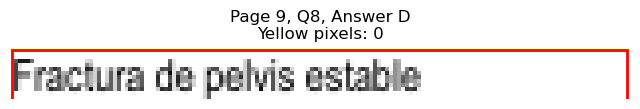


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=206.7, y1=657.5
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 694
Page 9, Q9, A: Yellow percentage: 0.0%


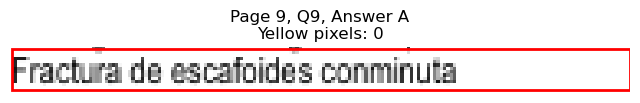

Page 9, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=246.4, y1=670.1
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 908
Page 9, Q9, B: Yellow percentage: 0.0%


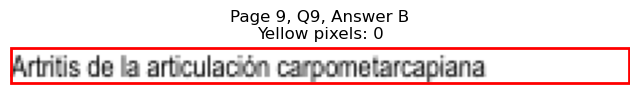

Page 9, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=444.9, y1=657.5
Page 9, Q9, C: Yellow pixels: 1734
Page 9, Q9, C: Total non-white pixels: 2352
Page 9, Q9, C: Yellow percentage: 73.7%


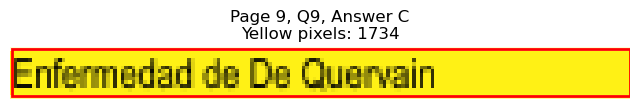

Page 9, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=408.3, y1=670.1
Page 9, Q9, D: Yellow pixels: 132
Page 9, Q9, D: Total non-white pixels: 526
Page 9, Q9, D: Yellow percentage: 25.1%


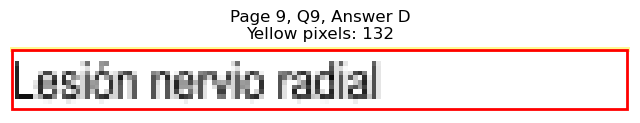


Page 9, Q9 - Selected Answer: C (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=708.0, x1=168.1, y1=720.6
Page 9, Q10, A: Yellow pixels: 151
Page 9, Q10, A: Total non-white pixels: 640
Page 9, Q10, A: Yellow percentage: 23.6%


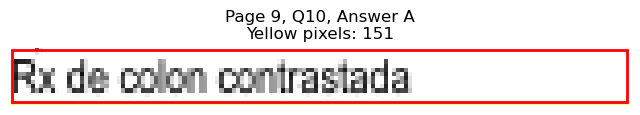

Page 9, Q10 - B: Detected box: x0=68.3, y0=720.6, x1=126.0, y1=733.2
Page 9, Q10, B: Yellow pixels: 1198
Page 9, Q10, B: Total non-white pixels: 1526
Page 9, Q10, B: Yellow percentage: 78.5%


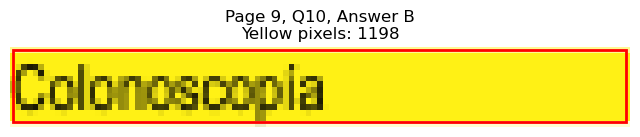

Page 9, Q10 - C: Detected box: x0=327.5, y0=708.0, x1=416.3, y1=720.6
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 472
Page 9, Q10, C: Yellow percentage: 0.0%


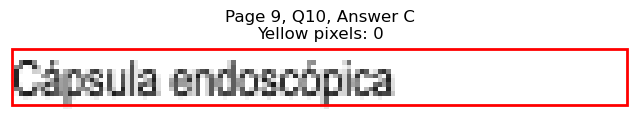

Page 9, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=373.7, y1=733.2
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 244
Page 9, Q10, D: Yellow percentage: 0.0%


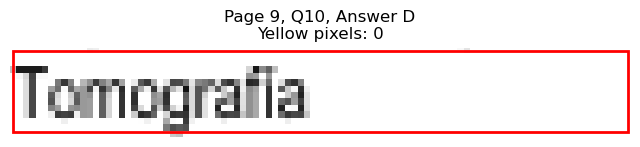


Page 9, Q10 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=163.1, y1=127.3
Page 10, Q1, A: Yellow pixels: 1378
Page 10, Q1, A: Total non-white pixels: 2044
Page 10, Q1, A: Yellow percentage: 67.4%


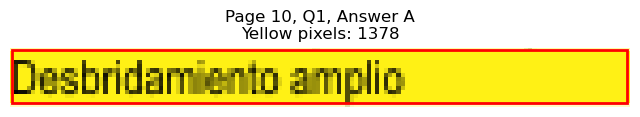

Page 10, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=179.7, y1=139.9
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 696
Page 10, Q1, B: Yellow percentage: 0.0%


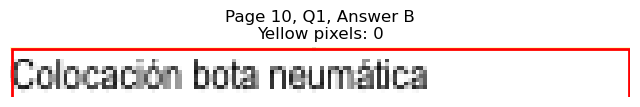

Page 10, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=427.4, y1=127.3
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 497
Page 10, Q1, C: Yellow percentage: 0.0%


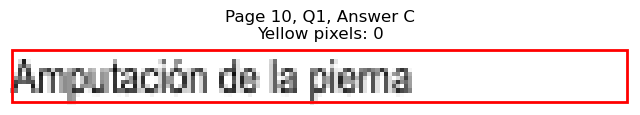

Page 10, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=391.3, y1=139.9
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 331
Page 10, Q1, D: Yellow percentage: 0.0%


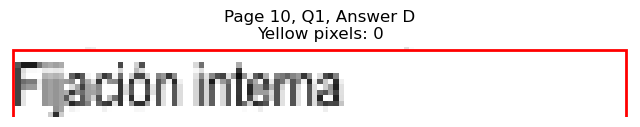


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=190.5, x1=240.8, y1=203.1
Page 10, Q2, A: Yellow pixels: 2085
Page 10, Q2, A: Total non-white pixels: 2996
Page 10, Q2, A: Yellow percentage: 69.6%


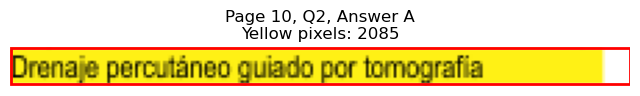

Page 10, Q2 - B: Detected box: x0=68.3, y0=203.1, x1=190.7, y1=215.7
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 788
Page 10, Q2, B: Yellow percentage: 0.0%


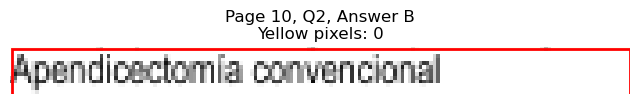

Page 10, Q2 - C: Detected box: x0=327.5, y0=190.5, x1=452.5, y1=203.1
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 653
Page 10, Q2, C: Yellow percentage: 0.0%


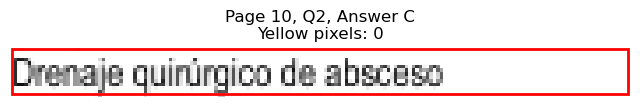

Page 10, Q2 - D: Detected box: x0=327.5, y0=203.1, x1=455.0, y1=215.7
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 655
Page 10, Q2, D: Yellow percentage: 0.0%


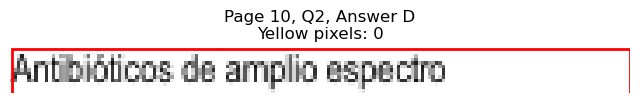


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=124.0, y1=253.5
Page 10, Q3, A: Yellow pixels: 1168
Page 10, Q3, A: Total non-white pixels: 1484
Page 10, Q3, A: Yellow percentage: 78.7%


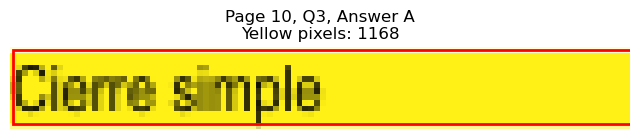

Page 10, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=149.3, y1=266.1
Page 10, Q3, B: Yellow pixels: 132
Page 10, Q3, B: Total non-white pixels: 499
Page 10, Q3, B: Yellow percentage: 26.5%


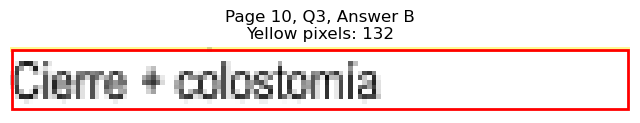

Page 10, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=394.7, y1=253.5
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 363
Page 10, Q3, C: Yellow percentage: 0.0%


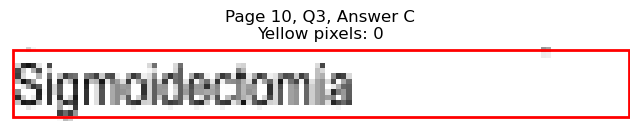

Page 10, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=378.2, y1=266.1
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 243
Page 10, Q3, D: Yellow percentage: 0.0%


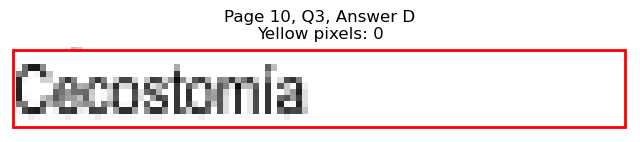


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=113.4, y1=304.1
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 233
Page 10, Q4, A: Yellow percentage: 0.0%


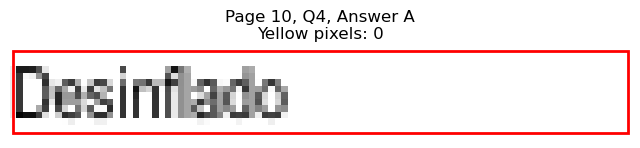

Page 10, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=97.9, y1=316.7
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 143
Page 10, Q4, B: Yellow percentage: 0.0%


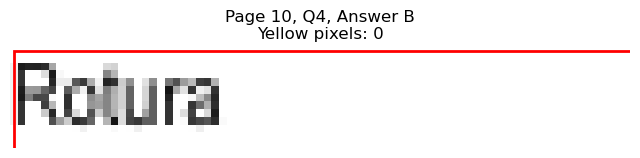

Page 10, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=394.7, y1=304.1
Page 10, Q4, C: Yellow pixels: 118
Page 10, Q4, C: Total non-white pixels: 478
Page 10, Q4, C: Yellow percentage: 24.7%


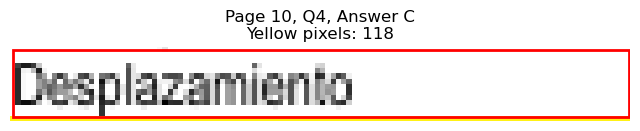

Page 10, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=413.8, y1=316.7
Page 10, Q4, D: Yellow pixels: 1449
Page 10, Q4, D: Total non-white pixels: 1781
Page 10, Q4, D: Yellow percentage: 81.4%


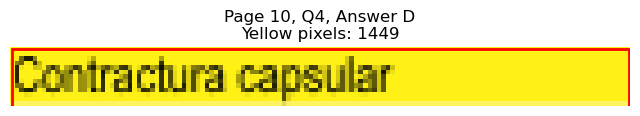


Page 10, Q4 - Selected Answer: D (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=177.1, y1=367.2
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 587
Page 10, Q5, A: Yellow percentage: 0.0%


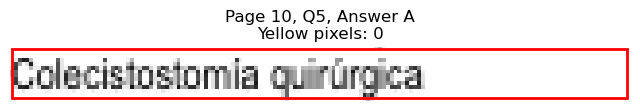

Page 10, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=164.1, y1=379.8
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 494
Page 10, Q5, B: Yellow percentage: 0.0%


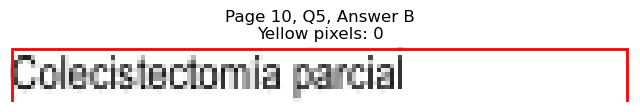

Page 10, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=413.8, y1=367.2
Page 10, Q5, C: Yellow pixels: 137
Page 10, Q5, C: Total non-white pixels: 569
Page 10, Q5, C: Yellow percentage: 24.1%


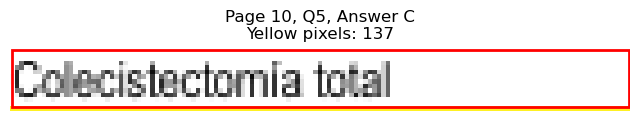

Page 10, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=441.9, y1=379.8
Page 10, Q5, D: Yellow pixels: 1689
Page 10, Q5, D: Total non-white pixels: 2145
Page 10, Q5, D: Yellow percentage: 78.7%


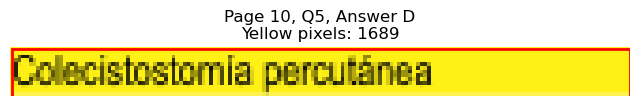


Page 10, Q5 - Selected Answer: D (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=405.0, x1=140.1, y1=417.7
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 373
Page 10, Q6, A: Yellow percentage: 0.0%


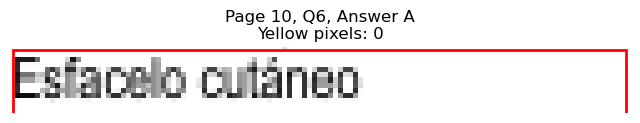

Page 10, Q6 - B: Detected box: x0=68.3, y0=417.6, x1=105.4, y1=430.3
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 200
Page 10, Q6, B: Yellow percentage: 0.0%


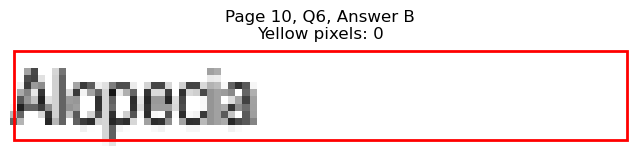

Page 10, Q6 - C: Detected box: x0=327.5, y0=405.0, x1=393.3, y1=417.7
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 433
Page 10, Q6, C: Yellow percentage: 0.0%


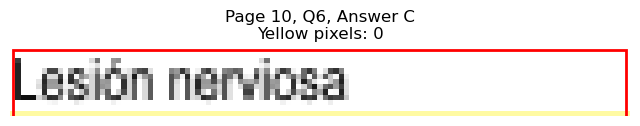

Page 10, Q6 - D: Detected box: x0=327.5, y0=417.6, x1=374.2, y1=430.3
Page 10, Q6, D: Yellow pixels: 990
Page 10, Q6, D: Total non-white pixels: 1372
Page 10, Q6, D: Yellow percentage: 72.2%


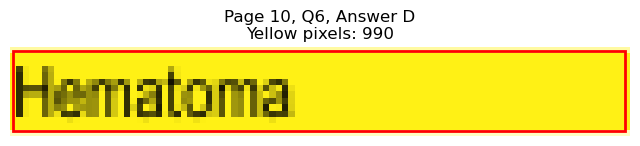


Page 10, Q6 - Selected Answer: D (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=175.6, y1=506.0
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 552
Page 10, Q7, A: Yellow percentage: 0.0%


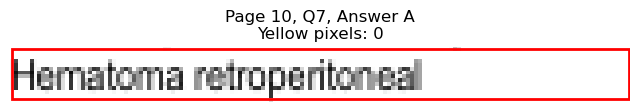

Page 10, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=130.9, y1=518.6
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 309
Page 10, Q7, B: Yellow percentage: 0.0%


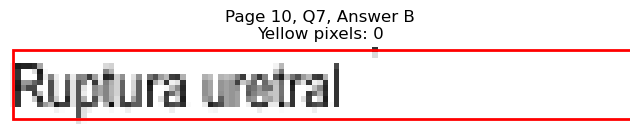

Page 10, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=451.9, y1=506.0
Page 10, Q7, C: Yellow pixels: 1764
Page 10, Q7, C: Total non-white pixels: 2278
Page 10, Q7, C: Yellow percentage: 77.4%


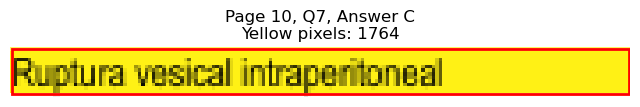

Page 10, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=425.3, y1=518.6
Page 10, Q7, D: Yellow pixels: 146
Page 10, Q7, D: Total non-white pixels: 636
Page 10, Q7, D: Yellow percentage: 23.0%


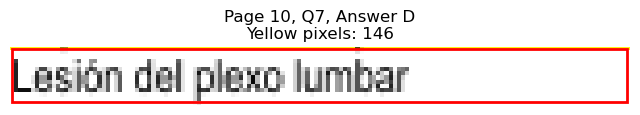


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=135.0, y1=569.2
Page 10, Q8, A: Yellow pixels: 118
Page 10, Q8, A: Total non-white pixels: 495
Page 10, Q8, A: Yellow percentage: 23.8%


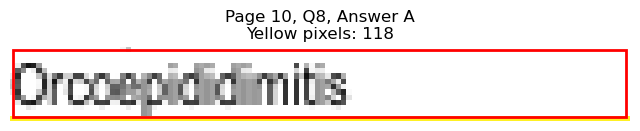

Page 10, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=113.9, y1=581.8
Page 10, Q8, B: Yellow pixels: 1069
Page 10, Q8, B: Total non-white pixels: 1248
Page 10, Q8, B: Yellow percentage: 85.7%


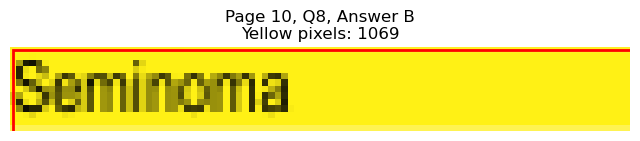

Page 10, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=368.2, y1=569.2
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 224
Page 10, Q8, C: Yellow percentage: 0.0%


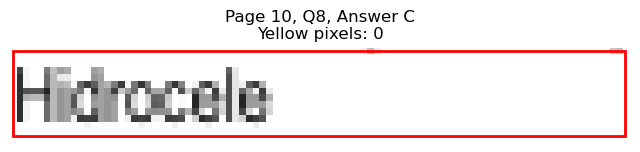

Page 10, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=393.2, y1=581.8
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 317
Page 10, Q8, D: Yellow percentage: 0.0%


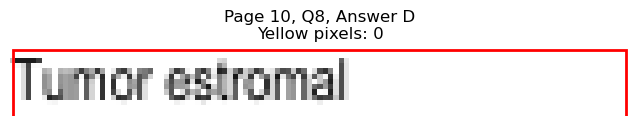


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=169.1, y1=632.3
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 504
Page 10, Q9, A: Yellow percentage: 0.0%


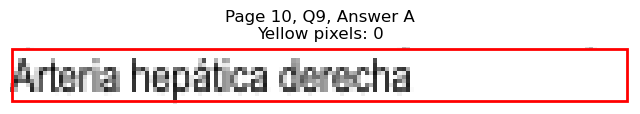

Page 10, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=115.0, y1=644.9
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 226
Page 10, Q9, B: Yellow percentage: 0.0%


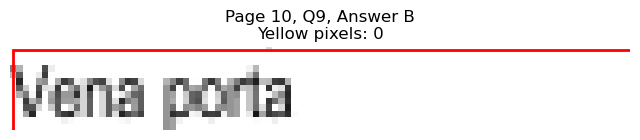

Page 10, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=401.8, y1=632.3
Page 10, Q9, C: Yellow pixels: 1219
Page 10, Q9, C: Total non-white pixels: 1750
Page 10, Q9, C: Yellow percentage: 69.7%


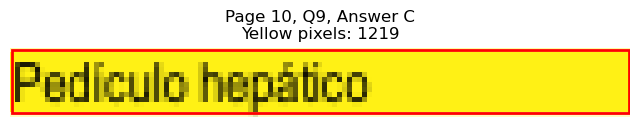

Page 10, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=403.3, y1=644.9
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 477
Page 10, Q9, D: Yellow percentage: 0.0%


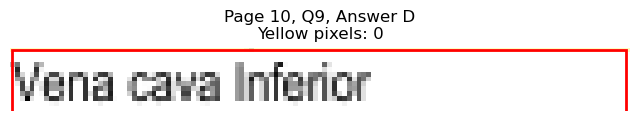


Page 10, Q9 - Selected Answer: C (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=68.3, y0=708.0, x1=204.8, y1=720.6
Page 10, Q10, A: Yellow pixels: 187
Page 10, Q10, A: Total non-white pixels: 876
Page 10, Q10, A: Yellow percentage: 21.3%


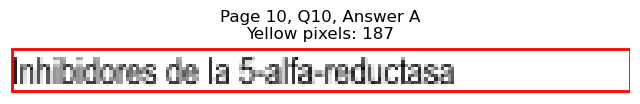

Page 10, Q10 - B: Detected box: x0=68.3, y0=720.6, x1=187.2, y1=733.2
Page 10, Q10, B: Yellow pixels: 1728
Page 10, Q10, B: Total non-white pixels: 2380
Page 10, Q10, B: Yellow percentage: 72.6%


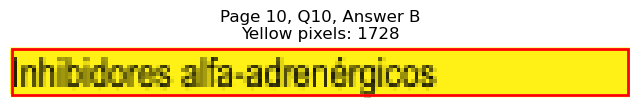

Page 10, Q10 - C: Detected box: x0=327.5, y0=708.0, x1=468.0, y1=720.6
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 714
Page 10, Q10, C: Yellow percentage: 0.0%


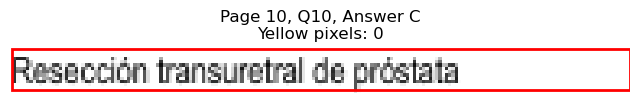

Page 10, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=442.4, y1=733.2
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 608
Page 10, Q10, D: Yellow percentage: 0.0%


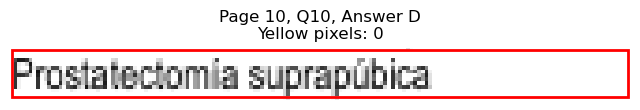


Page 10, Q10 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 2 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=194.7, y1=127.3
Page 11, Q1, A: Yellow pixels: 177
Page 11, Q1, A: Total non-white pixels: 843
Page 11, Q1, A: Yellow percentage: 21.0%


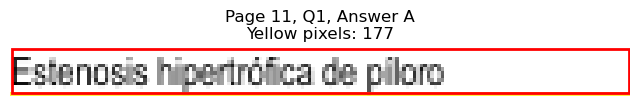

Page 11, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=140.1, y1=139.9
Page 11, Q1, B: Yellow pixels: 1305
Page 11, Q1, B: Total non-white pixels: 1599
Page 11, Q1, B: Yellow percentage: 81.6%


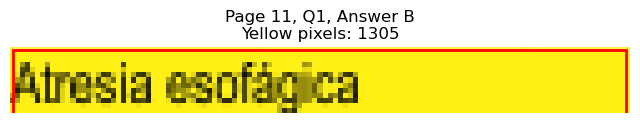

Page 11, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=424.4, y1=127.3
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 538
Page 11, Q1, C: Yellow percentage: 0.0%


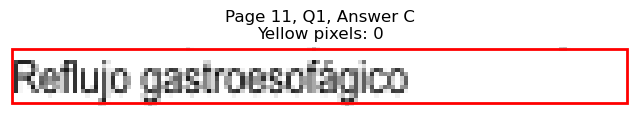

Page 11, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=384.7, y1=139.9
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 303
Page 11, Q1, D: Yellow percentage: 0.0%


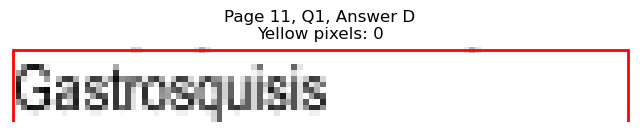


Page 11, Q1 - Selected Answer: B (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=121.5, y1=215.6
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 267
Page 11, Q2, A: Yellow percentage: 0.0%


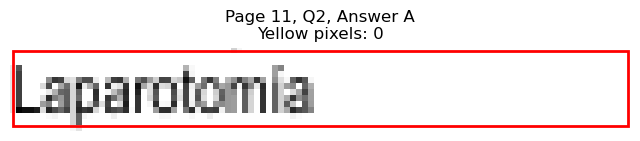

Page 11, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=95.9, y1=228.3
Page 11, Q2, B: Yellow pixels: 827
Page 11, Q2, B: Total non-white pixels: 1092
Page 11, Q2, B: Yellow percentage: 75.7%


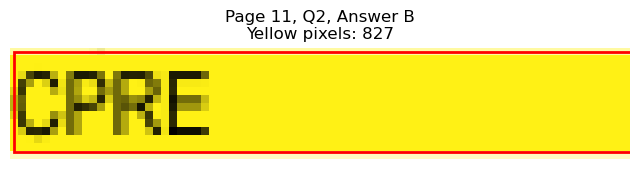

Page 11, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=384.8, y1=215.6
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 281
Page 11, Q2, C: Yellow percentage: 0.0%


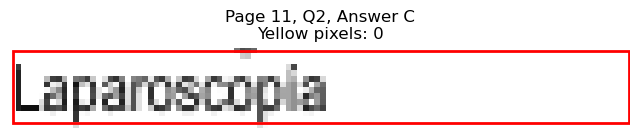

Page 11, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=428.4, y1=228.3
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 557
Page 11, Q2, D: Yellow percentage: 0.0%


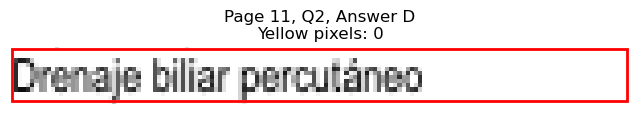


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 39 años acude por dolor cólico lumbar...
1   Varón de 56 años acude a emergencia porque des...
2   Mujer de 40 años es atendida por emergencia, p...
3   ¿Cuál es el procedimiento indicado en un pacie...
4   ¿Qué tipo de colgajo pedicular es el músculo g...
..                                                ...
95  Varón de 40 años acude a consulta por tumoraci...
96  ¿Cuál es el lugar de oclusión vascular intraop...
97  Varón de 75 años que consulta por presentar ch...
98  Recién nacido de tres días, con bajo peso, nac...
99  Mujer de 60 años, multípara que consulta por i...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0   Tomografía abdominopélvica sin contraste   
1                Observación con hidratación   
2                        Anestésicos tópicos   
3                            Colecistectomía   
4                       Dominante secundario   
..                                       ...   
95                          Orcoepididimitis   
96                  Arteria hepática derecha   
97        Inhibidores de la 5-alfa-reductasa   
98          Estenosis hipertrófica de píloro   
99                               Laparotomía   

                                    option_B  \
0   Tomografía abdominopélvica con contraste   
1                         Cirugía programada   
2                            Fotocoagulación   
3                                       CPRE   
4                                      Único   
..                                       ...   
95                                  Seminoma   
96                                Vena porta   
97             Inhibidores alfa-adrenérgicos   
98                         Atresia esofágica   
99                                      CPRE   

                                option_C                     option_D  
0   Cistografía ascendente con contraste    Ecografía abdominal total  
1               Laparatomía exploratoria  TAC abdominal con contraste  
2                            Crioterapia                     Escisión  
3                        Colecistostomía                Coledocotomía  
4                        Dominante doble                  Segmentario  
..                                   ...                          ...  
95                             Hidrocele               Tumor estromal  
96                     Pedículo hepático           Vena cava Inferior  
97    Resección transuretral de próstata   Prostatectomía suprapúbica  
98               Reflujo gastroesofágico                Gastrosquisis  
99                          Laparoscopía    Drenaje biliar percutáneo  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               C
2               D
3               B
4               B
..            ...
95              B
96              C
97              B
98              B
99              B

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón de 39 años acude por dolor cólico lumbar...   
1   Varón de 56 años acude a emergencia porque des...   
2   Mujer de 40 años es atendida por emergencia, p...   
3   ¿Cuál es el procedimiento indicado en un pacie...   
4   ¿Qué tipo de colgajo pedicular es el músculo g...   
..                                                ...   
95  Varón de 40 años acude a consulta por tumoraci...   
96  ¿Cuál es el lugar de oclusión vascular intraop...   
97  Varón de 75 años que consulta por presentar ch...   
98  Recién nacido de tres días, con bajo peso, nac...   
99  Mujer de 60 años, multípara que consulta por i...   

                                    option_A  \
0   Tomografía abdominopélvica sin contraste   
1                Observación con hidratación   
2                        Anestésicos tópicos   
3                            Colecistectomía   
4                       Dominante secundario   
..                                       ...   
95                          Orcoepididimitis   
96                  Arteria hepática derecha   
97        Inhibidores de la 5-alfa-reductasa   
98          Estenosis hipertrófica de píloro   
99                               Laparotomía   

                                    option_B  \
0   Tomografía abdominopélvica con contraste   
1                         Cirugía programada   
2                            Fotocoagulación   
3                                       CPRE   
4                                      Único   
..                                       ...   
95                                  Seminoma   
96                                Vena porta   
97             Inhibidores alfa-adrenérgicos   
98                         Atresia esofágica   
99                                      CPRE   

                                option_C                     option_D  \
0   Cistografía ascendente con contraste    Ecografía abdominal total   
1               Laparatomía exploratoria  TAC abdominal con contraste   
2                            Crioterapia                     Escisión   
3                        Colecistostomía                Coledocotomía   
4                        Dominante doble                  Segmentario   
..                                   ...                          ...   
95                             Hidrocele               Tumor estromal   
96                     Pedículo hepático           Vena cava Inferior   
97    Resección transuretral de próstata   Prostatectomía suprapúbica   
98               Reflujo gastroesofágico                Gastrosquisis   
99                          Laparoscopía    Drenaje biliar percutáneo   

   correct_answer  
0               A  
1               C  
2               D  
3               B  
4               B  
..            ...  
95              B  
96              C  
97              B  
98              B  
99              B  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/CIRUGIA GENERAL.csv
